In [1690]:
import re
from collections import Counter
from functools import partial

import grapheme
import pandas as pd

import mpl_axes_aligner.align
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(9872)
from scipy.stats import kendalltau
from tqdm import tqdm

from bokeh.models import HoverTool, ColumnDataSource
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_file, show, save, output_notebook
from bokeh.plotting import figure
from bokeh.models import Axis

import seaborn as sb

import unicodedata

from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# set cardo to be the default font for special glyphs
plt.rcParams["font.family"] = "Cardo"

## Preprocessing

In [1691]:
transcriptions = pd.read_excel('../data/silentvoices_manuscript_data.xlsx')
transcriptions['id'] = transcriptions['codex_sig'] + '-' + transcriptions['production unit'] + '-' + transcriptions['scribe']
transcriptions.head(5)

Unnamed: 0              codex_sig  transkribuspage  \
0           0  Brussel, KBR, 1805-08                7   
1           1  Brussel, KBR, 1805-08                7   
2           2  Brussel, KBR, 1805-08                8   
3           3  Brussel, KBR, 1805-08                8   
4           4  Brussel, KBR, 1805-08                9   

             image_filename  image_width  image_height region_type  \
0  0007_KBR_1805-08_1r.tiff         5186          7123      header   
1  0007_KBR_1805-08_1r.tiff         5186          7123   paragraph   
2  0008_KBR_1805-08_1v.tiff         5186          7123   paragraph   
3  0008_KBR_1805-08_1v.tiff         5186          7123  marginalia   
4  0009_KBR_1805-08_2r.tiff         5186          7123   paragraph   

                                         coordinates  \
0                1405,478 3598,478 3598,721 1405,721   
1              1359,751 3792,751 3792,2645 1359,2645   
2              1736,658 3985,658 3985,1643 1736,1643   
3            2414,1705 4016,1705 4016,1851 2414,1851   
4  859,5840 847,5678 835,5462 781,4838 751,4480 7...   

                                                text  reading_order  ...  \
0          Een voorredene op sinte gregoriꝰ dyalogus              0  ...   
1  DE zeere wise e saleghe gregoris paeus\nvan d...              1  ...   
2  wiste dat si hare te xpūs gheloeue ghege-\nuen...              0  ...   
3                  ⸫ Nēmeer en vant ics jnt latijn .              1  ...   
4  Hier beghint een voʼredene\nop .Sʼ. gᵉgorius d...              0  ...   

      language scribe production unit local Herne product  date  \
0  middledutch      a               I                 yes  1400   
1  middledutch      a               I                 yes  1400   
2  middledutch      a               I                 yes  1400   
3  middledutch      a               I                 yes  1400   
4  middledutch      α               I                 yes  1395   

        translator transcription HTR-model used CER?  \
0  bibletranslator            GT            NaN  NaN   
1  bibletranslator            GT            NaN  NaN   
2  bibletranslator            GT            NaN  NaN   
3  bibletranslator            GT            NaN  NaN   
4  bibletranslator            GT            NaN  NaN   

                          id  
0  Brussel, KBR, 1805-08-I-a  
1  Brussel, KBR, 1805-08-I-a  
2  Brussel, KBR, 1805-08-I-a  
3  Brussel, KBR, 1805-08-I-a  
4  Brussel, KBR, 1805-08-I-α  

[5 rows x 25 columns]

In [1692]:
units = []
plain_char = re.compile("[A-Za-z]+")

for pu_id, pu in transcriptions.groupby('id'):
    pu = pu.sort_values('transkribuspage')
    pu = pu[~pu['text'].isna()]
    if not len(pu):
        continue
    text = ' '.join(t for t in pu['text'])
    text = ' '.join(text.strip().split())
    
    date = pu.sample(1)['date'].values[0]
    scribe = pu.sample(1)['scribe'].values[0]
    sig = pu.sample(1)['codex_sig'].values[0]
    content = '<UNK>'
    try:
        content = ' - '.join(Counter(pu['content']))
    except:
        pass
    
    try:
        if plain_char.fullmatch(scribe):
            scribe = sig + '-' + scribe
    except TypeError:
        scribe = '<UNK>'
        
    translator = pu.sample(1)['translator'].values[0]
    units.append((pu_id, date, text, scribe, sig, pu_id, translator, content))

H = pd.DataFrame(units, columns=['pu', 'date', 'text', 'scribe', 'signature', 'id', 'translator', 'content'])
H.sample(10)

pu       date  \
74             Sint-Petersburg, BAN, O 256-I-B  1325-1350   
50                  Gent, UB, 941-I-II-scribe2  1375-1400   
5                  Brussel, KBR, 1805-08-III-β       1395   
33                     Brussel, KBR, 2979-II-α       1350   
42                    Brussel, KBR, 394-98-I-A  1373-1383   
109                         Wenen, ONB, 65-I-γ  1375-1400   
94                  Wenen, ONB, 13708-III-none       1402   
25   Brussel, KBR, 2879-80-III-scribe2-scribe3  1325-1350   
20             Brussel, KBR, 2879-80-I-scribe1  1325-1350   
62     Parijs, Bibliotheque Mazarine, 920-VI-L  1375-1400   

                                                  text  \
74                                                       
50   te comē plach ¶ Een Joncfrouwe van colne e hi...   
5    Jn de wihinghē vā dʼ kerkē beda sermoem Bhhed ...   
33   J theꝰ ghel seide dē wiuē ātwʼdende En wilt v ...   
42                                                       
109  ‡ d blie die pase on heeren ihoes so voerga en...   
94                                                .46.   
25   mi dat ic di ꝟwinne Jn dine onuʼ- wonnene crac...   
20   E wat hi u gh eloeft he uet GOd die de clare ...   
62   ⸫ Spiegel des sondʼs ⸫ O alre liefste broeder ...   

                                   scribe                           signature  \
74          Sint-Petersburg, BAN, O 256-B         Sint-Petersburg, BAN, O 256   
50                                scribe2                       Gent, UB, 941   
5                                       β               Brussel, KBR, 1805-08   
33                                      α                  Brussel, KBR, 2979   
42                 Brussel, KBR, 394-98-A                Brussel, KBR, 394-98   
109                                     γ                      Wenen, ONB, 65   
94                 Wenen, ONB, 13708-none                   Wenen, ONB, 13708   
25                        scribe2-scribe3               Brussel, KBR, 2879-80   
20                                scribe1               Brussel, KBR, 2879-80   
62   Parijs, Bibliotheque Mazarine, 920-L  Parijs, Bibliotheque Mazarine, 920   

                                            id translator  \
74             Sint-Petersburg, BAN, O 256-I-B        NaN   
50                  Gent, UB, 941-I-II-scribe2        NaN   
5                  Brussel, KBR, 1805-08-III-β       none   
33                     Brussel, KBR, 2979-II-α        NaN   
42                    Brussel, KBR, 394-98-I-A        NaN   
109                         Wenen, ONB, 65-I-γ        NaN   
94                  Wenen, ONB, 13708-III-none        NaN   
25   Brussel, KBR, 2879-80-III-scribe2-scribe3       none   
20             Brussel, KBR, 2879-80-I-scribe1       none   
62     Parijs, Bibliotheque Mazarine, 920-VI-L        NaN   

                                               content  
74                                           perikopen  
50                                   HadLijst-HadBrief  
5    preekBeda - preekBeda-preekPsBeda - preekPsBed...  
33                                            evangMat  
42                                            calendar  
109                                                TOC  
94                                                none  
25                                             HadLied  
20                                            HadBrief  
62                                     spiegelsondaren

In [1693]:
num_dates = []

for d in H['date']:
    if d in ('unknown', 'no'):
        d = None
    else:
        try:
            d = int(d)
        except ValueError:
            if '-' in d:
                d1, d2 = d.split('-')
                d1, d2 = int(d1), int(d2)
                d = d1 + ((d2 - d1) / 2)
            if d == 'none':
                d = None
    num_dates.append(d)
    
H['num_date'] = num_dates
H['length'] = H['text'].str.len()
H = H.sort_values('num_date')
H.head()

pu       date  \
25  Brussel, KBR, 2879-80-III-scribe2-scribe3  1325-1350   
26          Brussel, KBR, 2879-80-III-scribe3  1325-1350   
74            Sint-Petersburg, BAN, O 256-I-B  1325-1350   
24          Brussel, KBR, 2879-80-III-scribe2  1325-1350   
23           Brussel, KBR, 2879-80-II-scribe2  1325-1350   

                                                 text  \
25  mi dat ic di ꝟwinne Jn dine onuʼ- wonnene crac...   
26  Jc ben dat ic was wilen eer . Nu valle in mine...   
74                                                      
24  AY al es nu die winter cout Cort de daghe e d...   
23  HEt was in ene sōdage tʼ octauē vā pētecostē d...   

                           scribe                    signature  \
25                scribe2-scribe3        Brussel, KBR, 2879-80   
26                        scribe3        Brussel, KBR, 2879-80   
74  Sint-Petersburg, BAN, O 256-B  Sint-Petersburg, BAN, O 256   
24                        scribe2        Brussel, KBR, 2879-80   
23                        scribe2        Brussel, KBR, 2879-80   

                                           id translator  \
25  Brussel, KBR, 2879-80-III-scribe2-scribe3       none   
26          Brussel, KBR, 2879-80-III-scribe3       none   
74            Sint-Petersburg, BAN, O 256-I-B        NaN   
24          Brussel, KBR, 2879-80-III-scribe2       none   
23           Brussel, KBR, 2879-80-II-scribe2       none   

                                content  num_date  length  
25                              HadLied    1337.5    2264  
26  HadLied - HadLied-HadMeng - HadMeng    1337.5  118389  
74                            perikopen    1337.5       0  
24                              HadLied    1337.5   38565  
23  HadVis - HadVis-HadLijst - HadLijst    1337.5   90526

In [1694]:
# Filters out any text with a length less than 2500 characters
print(len(H))
H = H[H['length'] > 1000]
print(len(H))

113
75


In [1695]:
import altair as alt

# Group data by 'num_date' and sum the 'length' column
grouped_data = H.groupby('num_date')['length'].sum().reset_index()

# Calculate the total length for all dates
total_length = grouped_data['length'].sum()

# Calculate the percentage for each date
grouped_data['percentage'] = (grouped_data['length'] / total_length) * 100

# Create an Altair bar chart
bar_chart = alt.Chart(grouped_data).mark_bar().encode(
    x=alt.X('num_date:N', title='Date', axis=alt.Axis(labelAngle=0, labelFontSize=12)),
    y=alt.Y('length:Q', title='Sum of Text Lengths (characters)'),
    tooltip=['num_date', 'length']
).properties(
    width=800,
    height=400,
    title='Sum of Text Lengths per Date/Period'
)

# Create a text layer to display the percentage inside the bars
text_chart = alt.Chart(grouped_data).mark_text(align='center', baseline='bottom', dy=-5).encode(
    x=alt.X('num_date:N', title='Date', axis=alt.Axis(labelAngle=0, labelFontSize=12)),
    y=alt.Y('length:Q', title='Sum of Text Lengths (characters)'),
    text=alt.Text('percentage:N', format='.1f')
)

# Combine the bar chart and text chart
combined_chart = alt.layer(bar_chart, text_chart).properties(
    width=800,
    height=600
)

# Display the combined chart
combined_chart.display()


alt.LayerChart(...)

## Graphemes?

Elements allowed in ground truth?
Separate the characters into three categories: letters, glyphs, and punctuation

In [1696]:
allowed_chars = ''.join([t for t in transcriptions[transcriptions['transcription'] == 'GT']['text'] if isinstance(t, str)])
allowed_chars = Counter(allowed_chars)
allowed_chars

Counter({'E': 5679,
         'e': 216728,
         'n': 64373,
         ' ': 268208,
         'v': 17443,
         'o': 46691,
         'r': 36459,
         'd': 72093,
         'p': 8135,
         's': 64138,
         'i': 68690,
         't': 71726,
         'g': 32034,
         'ꝰ': 827,
         'y': 2052,
         'a': 51851,
         'l': 44463,
         'u': 20315,
         'D': 7105,
         'z': 1361,
         'w': 19666,
         '\ue5dc': 12826,
         'h': 47896,
         '\n': 43868,
         'm': 27302,
         'b': 14441,
         'c': 31747,
         'k': 9072,
         'ē': 44545,
         'ʼ': 24246,
         '.': 16694,
         'W': 2132,
         '-': 6835,
         'ū': 303,
         'ā': 8733,
         '\uf161': 50,
         'H': 1790,
         'j': 4791,
         'f': 5939,
         'x': 1842,
         '⸫': 212,
         'N': 1139,
         'S': 2019,
         'ᵉ': 1229,
         'O': 888,
         'ꝑ': 321,
         'ᵃ': 1511,
         'ꝫ': 7189,
         '

In [1697]:
plain_char = re.compile("[A-Za-z]+")

# these are also glyphs!
# but we need to add the manually, otherwise they're recognized as punctuation
unicode_glyphs = [u'\ue5dc', u'\ue554', u'\ue5b8', u'\ue665', u'ᷣ', u'̄', u'᷑',
                  u'\ue74d', u'\ue8e5', u'\ueed7', u'\ue681', u'\ue1dc', u'\ue154']

letters, glyphs, punctuation = [], [], []

for g, c in allowed_chars.items():
    # ignore:
    if g.isnumeric():
        continue
    if g.isspace():
        continue
    if plain_char.fullmatch(g):
        letters.append((g, c))
    elif g.isalpha() or g in unicode_glyphs:  # Include the custom-defined Unicode glyphs!!
        glyphs.append((g, c))
    else:
        punctuation.append((g, c))

letters = Counter(dict(letters))
glyphs = Counter(dict(glyphs))
punctuation = Counter(dict(punctuation))

print(letters.most_common(5))
print(glyphs.most_common(5))
print(punctuation.most_common(5))
print(glyphs)

[('e', 216728), ('d', 72093), ('t', 71726), ('i', 68690), ('n', 64373)]
[('ē', 44545), ('ʼ', 24246), ('\ue5dc', 12826), ('ī', 9056), ('ā', 8733)]
[('.', 16694), (':', 9738), ('-', 6835), ('¶', 716), ('⸫', 212)]
Counter({'ē': 44545, 'ʼ': 24246, '\ue5dc': 12826, 'ī': 9056, 'ā': 8733, 'ꝫ': 7189, 'ō': 5403, 'ᵗ': 3305, '\ue554': 2259, 'ᵃ': 1511, 'ᵒ': 1421, 'ᵉ': 1229, 'ꝟ': 1100, 'ꝰ': 827, 'ⁱ': 767, 'ⁿ': 393, '̄': 385, 'ꝑ': 321, '\ue5b8': 307, 'ū': 303, 'ᵛ': 293, '\ue665': 271, 'ꝓ': 242, 'ᷣ': 215, 'ꝯ': 178, 'Ō': 117, '᷑': 49, 'ˢ': 46, 'ħ': 43, 'ᶜ': 40, 'ẜ': 22, 'ᵐ': 22, 'ꝝ': 14, 'ð': 14, 'ᵈ': 12, 'Ꝑ': 12, 'ȳ': 11, 'ʳ': 10, 'ᵘ': 9, '\ue154': 8, 'ᶦ': 7, 'Ꝟ': 7, '\ue681': 6, 'Ā': 5, 'Ē': 4, 'ꞏ': 4, 'ꝙ': 2, 'ƶ': 2, '\ueed7': 1, 'ø': 1, 'ↄ': 1, '\ue1dc': 1, 'ȣ': 1, 'ω': 1, 'Ꝓ': 1, '\ue74d': 1, '\ue8e5': 1, 'Ꝝ': 1, 'Ꝯ': 1})


Only keep characters that are attested in the ground truth transcriptions:

In [1698]:
def clean(text):
    text = ' '.join(text.split())
    return ''.join([c for c in text if c in allowed_chars])

H['text'] = H['text'].apply(clean)
H

pu       date  \
25  Brussel, KBR, 2879-80-III-scribe2-scribe3  1325-1350   
26          Brussel, KBR, 2879-80-III-scribe3  1325-1350   
24          Brussel, KBR, 2879-80-III-scribe2  1325-1350   
23           Brussel, KBR, 2879-80-II-scribe2  1325-1350   
22            Brussel, KBR, 2879-80-I-scribe2  1325-1350   
..                                        ...        ...   
96                     Wenen, ONB, 13708-IV-α       1402   
95                    Wenen, ONB, 13708-III-α       1402   
93                     Wenen, ONB, 13708-II-α       1402   
98                     Wenen, ONB, 13708-IX-α       1402   
91                      Wenen, ONB, 13708-I-α       1402   

                                                 text           scribe  \
25  mi dat ic di ꝟwinne Jn dine onuʼ- wonnene crac...  scribe2-scribe3   
26  Jc ben dat ic was wilen eer . Nu valle in mine...          scribe3   
24  AY al es nu die winter cout Cort de daghe e d...          scribe2   
23  HEt was in ene sōdage tʼ octauē vā pētecostē d...          scribe2   
22  Niet opten loen Si beuelēt alder minnen dies e...          scribe2   
..                                                ...              ...   
96  Dander ptie Dē vorredene vā dē andʼen boeke WJ...                α   
95  ¶ Hoe petʼ ordineʼde clemēte Vaeus te sine na ...                α   
93  a Doemē screef .m.ccc. e .xcvi. op de derde n...                α   
98  Dander ꝑtie De seuēde boec De vor redene vā dē...                α   
91  pᵃ ꝓbaᵒ Jn dese na volgende qᵉstie wʼt gepᵛeft...                α   

                signature                                         id  \
25  Brussel, KBR, 2879-80  Brussel, KBR, 2879-80-III-scribe2-scribe3   
26  Brussel, KBR, 2879-80          Brussel, KBR, 2879-80-III-scribe3   
24  Brussel, KBR, 2879-80          Brussel, KBR, 2879-80-III-scribe2   
23  Brussel, KBR, 2879-80           Brussel, KBR, 2879-80-II-scribe2   
22  Brussel, KBR, 2879-80            Brussel, KBR, 2879-80-I-scribe2   
..                    ...                                        ...   
96      Wenen, ONB, 13708                     Wenen, ONB, 13708-IV-α   
95      Wenen, ONB, 13708                    Wenen, ONB, 13708-III-α   
93      Wenen, ONB, 13708                     Wenen, ONB, 13708-II-α   
98      Wenen, ONB, 13708                     Wenen, ONB, 13708-IX-α   
91      Wenen, ONB, 13708                      Wenen, ONB, 13708-I-α   

   translator                                            content  num_date  \
25       none                                            HadLied    1337.5   
26       none                HadLied - HadLied-HadMeng - HadMeng    1337.5   
24       none                                            HadLied    1337.5   
23       none                HadVis - HadVis-HadLijst - HadLijst    1337.5   
22       none                                           HadBrief    1337.5   
..        ...                                                ...       ...   
96        NaN                                             sph2-2    1402.0   
95        NaN                                             sph2-1    1402.0   
93        NaN  kroniekbrabant - sph4 - lekenspiegel - corpusi...    1402.0   
98        NaN                                             sph2-7    1402.0   
91        NaN                                          supermodo    1402.0   

    length  
25    2264  
26  118389  
24   38565  
23   90526  
22  112630  
..     ...  
96  109567  
95   96141  
93  147236  
98  151095  
91   28844  

[75 rows x 10 columns]

Remove punctuation:

In [1699]:
BREAK = re.compile(r'\-\s+')
NUMBER = re.compile(r'[0-9]+')

def rm_punct(text):
    text = re.sub(BREAK, '', text) # BREAK detects hyphenation breaks, deletes them
    text = re.sub(NUMBER, '', text) # NUMBER detects numeric characters, deletes them
    return ''.join([c for c in text if c not in punctuation])

H['text'] = H['text'].apply(rm_punct)
H

pu       date  \
25  Brussel, KBR, 2879-80-III-scribe2-scribe3  1325-1350   
26          Brussel, KBR, 2879-80-III-scribe3  1325-1350   
24          Brussel, KBR, 2879-80-III-scribe2  1325-1350   
23           Brussel, KBR, 2879-80-II-scribe2  1325-1350   
22            Brussel, KBR, 2879-80-I-scribe2  1325-1350   
..                                        ...        ...   
96                     Wenen, ONB, 13708-IV-α       1402   
95                    Wenen, ONB, 13708-III-α       1402   
93                     Wenen, ONB, 13708-II-α       1402   
98                     Wenen, ONB, 13708-IX-α       1402   
91                      Wenen, ONB, 13708-I-α       1402   

                                                 text           scribe  \
25  mi dat ic di ꝟwinne Jn dine onuʼwonnene cracht...  scribe2-scribe3   
26  Jc ben dat ic was wilen eer  Nu valle in minen...          scribe3   
24  AY al es nu die winter cout Cort de daghe e d...          scribe2   
23  HEt was in ene sōdage tʼ octauē vā pētecostē d...          scribe2   
22  Niet opten loen Si beuelēt alder minnen dies e...          scribe2   
..                                                ...              ...   
96  Dander ptie Dē vorredene vā dē andʼen boeke WJ...                α   
95   Hoe petʼ ordineʼde clemēte Vaeus te sine na h...                α   
93  a Doemē screef mccc e xcvi op de derde none v...                α   
98  Dander ꝑtie De seuēde boec De vor redene vā dē...                α   
91  pᵃ ꝓbaᵒ Jn dese na volgende qᵉstie wʼt gepᵛeft...                α   

                signature                                         id  \
25  Brussel, KBR, 2879-80  Brussel, KBR, 2879-80-III-scribe2-scribe3   
26  Brussel, KBR, 2879-80          Brussel, KBR, 2879-80-III-scribe3   
24  Brussel, KBR, 2879-80          Brussel, KBR, 2879-80-III-scribe2   
23  Brussel, KBR, 2879-80           Brussel, KBR, 2879-80-II-scribe2   
22  Brussel, KBR, 2879-80            Brussel, KBR, 2879-80-I-scribe2   
..                    ...                                        ...   
96      Wenen, ONB, 13708                     Wenen, ONB, 13708-IV-α   
95      Wenen, ONB, 13708                    Wenen, ONB, 13708-III-α   
93      Wenen, ONB, 13708                     Wenen, ONB, 13708-II-α   
98      Wenen, ONB, 13708                     Wenen, ONB, 13708-IX-α   
91      Wenen, ONB, 13708                      Wenen, ONB, 13708-I-α   

   translator                                            content  num_date  \
25       none                                            HadLied    1337.5   
26       none                HadLied - HadLied-HadMeng - HadMeng    1337.5   
24       none                                            HadLied    1337.5   
23       none                HadVis - HadVis-HadLijst - HadLijst    1337.5   
22       none                                           HadBrief    1337.5   
..        ...                                                ...       ...   
96        NaN                                             sph2-2    1402.0   
95        NaN                                             sph2-1    1402.0   
93        NaN  kroniekbrabant - sph4 - lekenspiegel - corpusi...    1402.0   
98        NaN                                             sph2-7    1402.0   
91        NaN                                          supermodo    1402.0   

    length  
25    2264  
26  118389  
24   38565  
23   90526  
22  112630  
..     ...  
96  109567  
95   96141  
93  147236  
98  151095  
91   28844  

[75 rows x 10 columns]

## Visualize

In [1700]:
segment_size = 5000
segments = []
for _, row in H.iterrows():
    si, ei = 0, segment_size
    text = row['text']
    while ei < len(text):
        segments.append((text[si:ei], row['num_date'], row['scribe'], row['signature'], row['id'], row['translator'], row['content']))
        si += segment_size
        ei += segment_size

segments = pd.DataFrame(segments, columns=['text', 'date', 'scribe', 'signature', 'id', 'translator', 'content'])
segments.sample(5)

text    date  \
67   herieuē E mē wilt vele van Mⁿ hebbē e lettel...  1337.5   
104   tēpel gods hꝫ es niet  E die swerꝫ ī dat gou...  1337.5   
744  ē wilt nᵗ gelijct wʼdē desʼ wʼelt maʼ wʼdt hʼf...  1387.5   
658  t gi mi nᵗ ē geloeuets  d dꝫ gi mi geheilechs ...  1387.5   
694   staē vā isrlʼ  e hi sal slaē moabs hʼtogē  a...  1387.5   

                            scribe                    signature  \
67                         scribe2        Brussel, KBR, 2879-80   
104  Sint-Petersburg, BAN, O 256-G  Sint-Petersburg, BAN, O 256   
744                              α        Brussel, KBR, 2849-51   
658                              α        Brussel, KBR, 2849-51   
694                              α        Brussel, KBR, 2905-09   

                                   id translator  \
67    Brussel, KBR, 2879-80-I-scribe2       none   
104  Sint-Petersburg, BAN, O 256-II-G        NaN   
744       Brussel, KBR, 2849-51-III-α        NaN   
658       Brussel, KBR, 2849-51-VII-α        NaN   
694        Brussel, KBR, 2905-09-II-α        NaN   

                                               content  
67                                            HadBrief  
104                                          evangMath  
744                                   briefPaulusadRom  
658                                        perikopenOT  
694  inhoudsopgave - inhoudsopgave-proloog - proloo...

Abbreviation density?

In [1701]:
def abbr_density(text):
    cnts = Counter(unicodedata.normalize('NFC', text))
    alph = np.sum([cnts[c] for c in set(letters)])
    glph = np.sum([cnts[c] for c in set(glyphs)])
    return glph / alph
    
densities = [abbr_density(t) for t in segments['text']]
segments['abbr'] = densities

In [1702]:
from collections import Counter
import numpy as np
import unicodedata
import re

def abbr_density_word(text, counter):
    # this is a chatgpt-generated regex, but i was at wits end for matching all abbreviation characters...
    words = re.findall(r'\b(?:[\w\u0101\u0100\u0113\u0112\u012b\u012A\u014D\u014C\u016B\u016A\u0233\u0232\u0304\uE554\uE154\uE5B8\uE5DC\uE665\uE681]+)(?=\b|$)', text.lower())
    num_abbr_words = 0
    num_total_words = 0
    abbr_words = []
    
    for word in words:
        if '\u016A' in word:
            print(f"Word containing '\\u016A': {word}")

    for word in words:
        cnts = Counter(unicodedata.normalize('NFD', word))
        alph = np.sum([cnts[c] for c in set(letters)])
        glph = np.sum([counter[c] for c in cnts if c in counter])

        if glph > 0:
            num_abbr_words += 1
            abbr_words.append(word)

        num_total_words += 1

    density = num_abbr_words / num_total_words
    return density, abbr_words

densities_word = []
abbreviated_words = []

for t in segments['text']:
    density, abbr_words = abbr_density_word(t, glyphs)
    densities_word.append(density)
    abbreviated_words.extend(abbr_words)

segments['abbr_word'] = densities_word

In [1703]:
segments

text    date   scribe  \
0     Jc ben dat ic was wilen eer  Nu valle in minen...  1337.5  scribe3   
1     elheit miere sinne  Dat ic doege ō hoeghe mᵉ w...  1337.5  scribe3   
2     Nu moete ons god beraden Men vendet in mⁿ sale...  1337.5  scribe3   
3     uet Mocht die vʼwoede beghʼte ghedoghen  Die a...  1337.5  scribe3   
4     de ghewinnen  en der mⁿ cost in ellende bekinn...  1337.5  scribe3   
...                                                 ...     ...      ...   
1195  pᵃ ꝓbaᵒ Jn dese na volgende qᵉstie wʼt gepᵛeft...  1402.0        α   
1196  gende te hare di moꝫ si vornemēde sorge de go...  1402.0        α   
1197  aʼ teerlīge e spele selē wi vindē bi vele lie...  1402.0        α   
1198  atine gekeʼt  op datse alle mēschē gʼekē e ba...  1402.0        α   
1199  maect si  die vā hoegʼ e van gᵒtʼ matʼiē tᵃc...  1402.0        α   

                  signature                                 id translator  \
0     Brussel, KBR, 2879-80  Brussel, KBR, 2879-80-III-scribe3       none   
1     Brussel, KBR, 2879-80  Brussel, KBR, 2879-80-III-scribe3       none   
2     Brussel, KBR, 2879-80  Brussel, KBR, 2879-80-III-scribe3       none   
3     Brussel, KBR, 2879-80  Brussel, KBR, 2879-80-III-scribe3       none   
4     Brussel, KBR, 2879-80  Brussel, KBR, 2879-80-III-scribe3       none   
...                     ...                                ...        ...   
1195      Wenen, ONB, 13708              Wenen, ONB, 13708-I-α        NaN   
1196      Wenen, ONB, 13708              Wenen, ONB, 13708-I-α        NaN   
1197      Wenen, ONB, 13708              Wenen, ONB, 13708-I-α        NaN   
1198      Wenen, ONB, 13708              Wenen, ONB, 13708-I-α        NaN   
1199      Wenen, ONB, 13708              Wenen, ONB, 13708-I-α        NaN   

                                  content      abbr  abbr_word  
0     HadLied - HadLied-HadMeng - HadMeng  0.056634   0.175258  
1     HadLied - HadLied-HadMeng - HadMeng  0.055780   0.169247  
2     HadLied - HadLied-HadMeng - HadMeng  0.051552   0.160164  
3     HadLied - HadLied-HadMeng - HadMeng  0.052518   0.155350  
4     HadLied - HadLied-HadMeng - HadMeng  0.042930   0.136082  
...                                   ...       ...        ...  
1195                            supermodo  0.178529   0.471357  
1196                            supermodo  0.193282   0.479520  
1197                            supermodo  0.183846   0.468214  
1198                            supermodo  0.202186   0.522234  
1199                            supermodo  0.190893   0.507277  

[1200 rows x 9 columns]

In [1704]:
# Filter the segments DataFrame for scribe alpha
scribe_alpha_segments = segments[segments['scribe'] == 'α']

# Calculate the average abbreviation density
average_density_scribe_alpha = scribe_alpha_segments['abbr_word'].mean()
print(average_density_scribe_alpha)
############

# Filter the segments DataFrame for scribe epsilon
scribe_alpha_segments = segments[segments['scribe'] == 'β']

# Calculate the average abbreviation density
average_density_scribe_alpha = scribe_alpha_segments['abbr_word'].mean()
print(average_density_scribe_alpha)
############


# Filter the segments DataFrame for scribe epsilon
scribe_alpha_segments = segments[segments['scribe'] == 'ε']

# Calculate the average abbreviation density
average_density_scribe_alpha = scribe_alpha_segments['abbr_word'].mean()
print(average_density_scribe_alpha)
############

# Filter the segments DataFrame for scribe epsilon
scribe_alpha_segments = segments[segments['scribe'] == 'γ']

# Calculate the average abbreviation density
average_density_scribe_alpha = scribe_alpha_segments['abbr_word'].mean()
print(average_density_scribe_alpha)
############

0.38464858397702123
0.36977129278143434
0.46347385213127773
0.27971832980845174


In [1705]:
#  mean abbreviation density for each scribe

# calculate mean abbreviation rate for each scribe
mean_abbr_rate = segments.groupby('scribe')['abbr'].mean().reset_index()

# horizontal bar chart
chart = alt.Chart(mean_abbr_rate).mark_bar().encode(
    x=alt.X('abbr:Q', title='Mean abbreviation density'),
    y=alt.Y('scribe:N', title='Scribe', sort=alt.EncodingSortField(field='abbr', order='descending'), axis=alt.Axis(labelFontSize=11))
)

chart = chart.properties(
    width=800,
    height=600
)

chart.display()

alt.Chart(...)

In [1706]:
# filter data and calculate the mean abbreviation frequency
filtered_data = segments[segments['scribe'] == 'α'].groupby('signature')['abbr'].mean().reset_index()

chart = alt.Chart(filtered_data).mark_bar().encode(
    y=alt.Y('signature:N', sort='-x', title='Manuscript signature', axis=alt.Axis(labelFontSize=14)),
    x=alt.X('abbr:Q', title='Mean abbreviation density')
).properties(
    width=1000,
    height=600,
    title='Mean abbreviation density for Scribe α by manuscript signature'
)

chart.display()

alt.Chart(...)

In [1707]:
import altair as alt

# Filter the data and calculate the mean abbreviation frequency for Scribe α
filtered_data_alpha = segments[segments['scribe'] == 'α'].groupby('signature')['abbr'].mean().reset_index()

# Create the horizontal bar plot for Scribe α
chart_alpha = alt.Chart(filtered_data_alpha).mark_bar(size=20).encode(
    y=alt.Y('signature:N', sort='-x', title='Manuscript signature'),
    x=alt.X('abbr:Q', title='Mean abbreviation density', scale=alt.Scale(zero=False)),
    color=alt.value('#1f77b4')  # Blue color for Scribe α
).properties(
    width=400,
    height=400,
    title='Mean abbreviation frequency for Scribe α by manuscript signature'
)

# Filter the data and calculate the mean abbreviation frequency for Scribe β
filtered_data_beta = segments[segments['scribe'] == 'β'].groupby('signature')['abbr'].mean().reset_index()

# Create the horizontal bar plot for Scribe β
chart_beta = alt.Chart(filtered_data_beta).mark_bar(size=20).encode(
    y=alt.Y('signature:N', sort='-x', title=None),
    x=alt.X('abbr:Q', title='Mean abbreviation density', scale=alt.Scale(zero=False)),
    color=alt.value('#ff7f0e')  # Orange color for Scribe β
).properties(
    width=400,
    height=400,
    title='Mean abbreviation density for Scribe β by manuscript signature'
)

# Combine the charts side by side with a shared x-axis
final_chart = alt.hconcat(chart_alpha, chart_beta).resolve_scale(x='shared')

# Display the plot
final_chart.display()

alt.HConcatChart(...)

In [1708]:
# Add the 'class' column to the segments DataFrame
classes = ['Wenen, ÖNB, 65' if sig == 'Wenen, ONB, 65' else 'Rest' for sig in segments['signature']]
segments['class'] = classes

# Filter the data for Scribe α
filtered_data = segments[segments['scribe'] == 'α']

# Create the box plot
chart = alt.Chart(filtered_data).mark_boxplot(size=60).encode(
    x=alt.X('class:N', title='Class', axis=alt.Axis(labelAngle=-25)),
    y=alt.Y('abbr:Q', title='Abbreviation density')
).properties(
    width=600,
    height=400,
    title='Boxplot of abbreviation density for Scribe α by class'
)

# Display the plot
chart.display()

alt.Chart(...)

## Derde Martijn

In [1709]:
with open('../data/derde_martijn/Ghent1374_DerdeMartijn.txt') as f:
    G = f.read()
with open('../data/derde_martijn/ONB13708_DerdeMartijn.txt') as f:
    W = f.read()

G = clean(rm_punct(G))
W = clean(rm_punct(W))

print(G[:100])
print(W[:100])

print('Ghent:', abbr_density(G).round(4))
print('Vienna:', abbr_density(W).round(4))

En̄ hier volgt de dʼde boec IC māne mettē wiuē Die dit gedichte lesē en̄ scᶦuē Op dē hoechstē ban Dꝫ
Hier willic settē dē dʼdē boec vā wapen mʼtē die iacob vā marlāt maecte ō dꝫ hi vā dē ge loeue spᵉct
Ghent: 0.1474
Vienna: 0.0851


In [1710]:
def segment(text, segment_size=100):
    segments = []
    si, ei = 0, segment_size
    while ei < len(text):
        segment_text = text[si:ei]
        segments.append((len(segments), segment_text))
        si += segment_size
        ei += segment_size
    return segments

segment_size = 100
Gs = segment(G, segment_size)
Ws = segment(W, segment_size)

densities = []

for g in Gs:
    index, segment_text = g
    density = abbr_density(segment_text)
    densities.append(('Ghent, UB, 1374', index, density, segment_text))
for w in Ws:
    index, segment_text = w
    density = abbr_density(segment_text)
    densities.append(('Vienna, ÖNB, 13708', index, density, segment_text))
densities = pd.DataFrame(densities, columns=['MS', 'segment_index', 'density', 'segment_text'])

In [1711]:
import altair as alt

# Add a new column with the segment index
densities['segment_index'] = list(range(len(densities)))

# Create a box plot
box_plot = alt.Chart(densities).mark_boxplot(size=100).encode(
    x=alt.X('MS:N', title='Manuscript', axis=alt.Axis(labelAngle=0), sort=['Ghent, UB, 1374', 'Vienna, ÖNB, 13708']),
    y=alt.Y('density:Q', title='Abbreviation Density'),
    color=alt.Color('MS:N', title='Manuscript', legend=alt.Legend(symbolSize=200, titleFontSize=14, labelFontSize=16))
)

# Create a point plot
point_plot = alt.Chart(densities).mark_circle(size=80, opacity=0.7).encode(
    x=alt.X('MS:N', title='Manuscript', axis=alt.Axis(labelAngle=0),sort=['Ghent, UB, 1374','Vienna, ÖNB, 13708']),
    y=alt.Y('density:Q', title='Abbreviation Density'),
    color=alt.Color('MS:N', title='Manuscript'),
    tooltip=['MS', 'segment_index', 'density']
)

# Combine the box plot and point plot
combined_plot = alt.layer(box_plot, point_plot).properties(
    width=300,
    height=400
).interactive()

# Display the plot
combined_plot.display()


alt.LayerChart(...)

In [1712]:
# inspect specific segments:
segment_text = densities.iloc[265]['segment_text']
print(segment_text)
cnts = Counter(unicodedata.normalize('NFC', segment_text))
alph = np.sum([cnts[c] for c in set(letters)])
glph = np.sum([cnts[c] for c in set(glyphs)])
print('Abbreviation Density:', glph / alph)

se en̄ spelle Magic leeren alsict vertelle Mijn geloeue al bloet Daer ic bi scumen mach die helle Op
Abbreviation Density: 0.012345679012345678


## Vectorization

In [1713]:
#segments = segments[segments['scribe'].isin(['α', 'β'])]
#segments = segments[segments['scribe'] == 'α']

In [1714]:
import unicodedata

def ngrams(text, ngram_size=1, glyphs_only=True, graphemic=True):
    if graphemic:
        chars = [g for g in grapheme.graphemes(text) if g]
    else:
        chars = list(unicodedata.normalize('NFC', text))
    
    for idx in range(len(chars)-(ngram_size-1)):
        gram = text[idx:idx+ngram_size]
        if glyphs_only:
            glyph_present = False
            for char in gram:
                if char in glyphs:
                    glyph_present = True
            if glyph_present:
                yield gram
            else:
                continue
        else:
            yield ''.join(gram)
    
params = {'use_idf': True,
          'max_features': 100,
          'analyzer': partial(ngrams,
                              graphemic=True,
                              ngram_size=2,
                              glyphs_only=True),
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(segments['text']).toarray()
BOW = preprocessing.scale(BOW)
BOW.shape

(1200, 100)

In [1715]:
print(vectorizer.get_feature_names_out())

[' ā' ' ē' ' ī' ' ō' ' ꝟ' 'E\ue5dc' 'Wā' 'aē' 'aʼ' 'bē' 'dā' 'dē' 'dī'
 'dʼ' 'dꝫ' 'eʼ' 'e\ue5dc' 'gē' 'gᵒ' 'hā' 'hē' 'hʼ' 'hᵗ' 'hꝫ' 'iē' 'iʼ'
 'i\ue554' 'kē' 'kī' 'kʼ' 'lē' 'lʼ' 'mā' 'mē' 'mī' 'mʼ' 'mꝫ' 'nē' 'nᵗ'
 'oē' 'oʼ' 'oꝫ' 'pē' 'qᵃ' 'rē' 'sē' 'sō' 'tē' 'tʼ' 'uē' 'uʼ' 'vā' 'vʼ'
 'wā' 'wē' 'wʼ' 'ā ' 'ād' 'āt' 'ē ' 'ēd' 'ēn' 'ēs' 'ēt' 'ī ' 'īc' 'īd'
 'īg' 'īn' 'īt' 'ō ' 'ōd' 'ōg' 'ōm' 'ōs' 'ōt' 'ʼ ' 'ʼc' 'ʼd' 'ʼe' 'ʼh'
 'ʼk' 'ʼl' 'ʼm' 'ʼn' 'ʼr' 'ʼs' 'ʼt' 'ʼw' 'ᵃc' 'ᵃm' 'ᵉ ' 'ᵒe' 'ᵒt' 'ᵗ '
 'ⁿ ' 'ꝫ ' 'ꝰ ' '\ue554 ' '\ue5dc ']


In [1716]:
pca = PCA(n_components=50)
X = pca.fit_transform(BOW)
print(X.shape)
tsne = TSNE(n_components=2)
X = tsne.fit_transform(X)
print(X.shape)

(1200, 50)


/Users/wouter/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/wouter/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1200, 2)


In [1717]:
output_notebook()

Loading BokehJS ...

In [1720]:
def scatterplot(X, df, label_column=None, color_column=None):
    if color_column:
        ints = [int(i) for i in LabelEncoder().fit_transform([str(i) for i in df[color_column]])]
        colors = sb.color_palette('husl', n_colors=len(set(ints)))
    else:
        ints = AgglomerativeClustering(n_clusters=8).fit_predict(X)
        colors = sb.color_palette('husl', n_colors=8)
    
    colors = [tuple([int(c * 256) for c in color]) for color in colors]
    
    meta_fields = ['scribe', 'id', 'date', 'translator', 'content']
    d = {c:list(df[c]) for c in meta_fields}
    d['color'] = ['#%02x%02x%02x' % colors[i] for i in ints]
    d['x'] = X[:, 0]
    d['y'] = X[:, 1]
    d['date'] = df['date'].astype(int)
    source = ColumnDataSource(data=d)

    TOOLS="pan,wheel_zoom,reset,hover,box_select,save"
    #output_file('herne.html')

    p = figure(title='Embeddings',
               tools=TOOLS,
               outer_width=1000,
               outer_height=800,
               outline_line_color="white")

    p.circle(x='x', y='y', color='color',
             source=source, size=8,
             fill_alpha=0.9, line_color=None)
    
    if label_column:
        for label, x, y in zip(df[label_column], X[:,0], X[:,1]):
            if isinstance(label, str):
                p.text(x, y, text=[label], text_align="center", text_font_size="10pt")

    hover = p.select(dict(type=HoverTool))
    hover.tooltips = [(c, '@'+c) for c in meta_fields]
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_label_text_font_size = '0pt'

    # Turn off tick marks
    p.axis.major_tick_line_color = None
    p.axis[0].ticker.num_minor_ticks = 0
    p.axis[1].ticker.num_minor_ticks = 0
    show(p)

scatterplot(X, segments, label_column=None, color_column='scribe')

In [1680]:
def scatterplot(X, df, label_column=None, color_column=None):
    if color_column:
        ints = [int(i) for i in LabelEncoder().fit_transform([str(i) for i in df[color_column]])]
        colors = sb.color_palette('husl', n_colors=len(set(ints)))
    else:
        ints = AgglomerativeClustering(n_clusters=8).fit_predict(X)
        colors = sb.color_palette('husl', n_colors=8)

    colors = [tuple([int(c * 256) for c in color]) for color in colors]

    meta_fields = ['scribe', 'id', 'date', 'translator', 'content']
    d = {c:list(df[c]) for c in meta_fields}
    d['color'] = ['#%02x%02x%02x' % colors[i] for i in ints]
    d['x'] = X[:, 0]
    d['y'] = X[:, 1]
    d['date'] = df['date'].astype(int)
    source = ColumnDataSource(data=d)

    TOOLS="pan,wheel_zoom,reset,hover,box_select,save"
    #output_file('herne.html')

    p = figure(title='Embeddings',
               tools=TOOLS,
               outer_width=1000,
               outer_height=800,
               outline_line_color="white")

    p.circle(x='x', y='y', color='color',
             source=source, size=8,
             fill_alpha=0.9, line_color=None)

    if label_column:
        for label, x, y in zip(df[label_column], X[:,0], X[:,1]):
            if isinstance(label, str):
                p.text(x, y, text=[label], text_align="center", text_font_size="10pt")

    hover = p.select(dict(type=HoverTool))
    hover.tooltips = [(c, '@'+c) for c in meta_fields]

    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_label_text_font_size = '0pt'

    # Turn off tick marks
    p.axis.major_tick_line_color = None
    p.axis[0].ticker.num_minor_ticks = 0
    p.axis[1].ticker.num_minor_ticks = 0
    show(p)
scatterplot(X, segments, label_column=None, color_column='id')

## Gamma: classification

In [1681]:
segments

text    date   scribe  \
0     Jc ben dat ic was wilen eer  Nu valle in minen...  1337.5  scribe3   
1     elheit miere sinne  Dat ic doege ō hoeghe mᵉ w...  1337.5  scribe3   
2     Nu moete ons god beraden Men vendet in mⁿ sale...  1337.5  scribe3   
3     uet Mocht die vʼwoede beghʼte ghedoghen  Die a...  1337.5  scribe3   
4     de ghewinnen  en der mⁿ cost in ellende bekinn...  1337.5  scribe3   
...                                                 ...     ...      ...   
1195  pᵃ ꝓbaᵒ Jn dese na volgende qᵉstie wʼt gepᵛeft...  1402.0        α   
1196  gende te hare di moꝫ si vornemēde sorge de go...  1402.0        α   
1197  aʼ teerlīge e spele selē wi vindē bi vele lie...  1402.0        α   
1198  atine gekeʼt  op datse alle mēschē gʼekē e ba...  1402.0        α   
1199  maect si  die vā hoegʼ e van gᵒtʼ matʼiē tᵃc...  1402.0        α   

                  signature                                 id translator  \
0     Brussel, KBR, 2879-80  Brussel, KBR, 2879-80-III-scribe3       none   
1     Brussel, KBR, 2879-80  Brussel, KBR, 2879-80-III-scribe3       none   
2     Brussel, KBR, 2879-80  Brussel, KBR, 2879-80-III-scribe3       none   
3     Brussel, KBR, 2879-80  Brussel, KBR, 2879-80-III-scribe3       none   
4     Brussel, KBR, 2879-80  Brussel, KBR, 2879-80-III-scribe3       none   
...                     ...                                ...        ...   
1195      Wenen, ONB, 13708              Wenen, ONB, 13708-I-α        NaN   
1196      Wenen, ONB, 13708              Wenen, ONB, 13708-I-α        NaN   
1197      Wenen, ONB, 13708              Wenen, ONB, 13708-I-α        NaN   
1198      Wenen, ONB, 13708              Wenen, ONB, 13708-I-α        NaN   
1199      Wenen, ONB, 13708              Wenen, ONB, 13708-I-α        NaN   

                                  content      abbr class  
0     HadLied - HadLied-HadMeng - HadMeng  0.056634  Rest  
1     HadLied - HadLied-HadMeng - HadMeng  0.055780  Rest  
2     HadLied - HadLied-HadMeng - HadMeng  0.051552  Rest  
3     HadLied - HadLied-HadMeng - HadMeng  0.052518  Rest  
4     HadLied - HadLied-HadMeng - HadMeng  0.042930  Rest  
...                                   ...       ...   ...  
1195                            supermodo  0.178529  Rest  
1196                            supermodo  0.193282  Rest  
1197                            supermodo  0.183846  Rest  
1198                            supermodo  0.202186  Rest  
1199                            supermodo  0.190893  Rest  

[1200 rows x 9 columns]

In [1682]:
### UNCOMMENT IF YOU DONT WANT TO EXCLUDE ANYTHING

# exclude segments with 'scribe2' and 'Brussel, KBR, 2877-78-A'
excluded_scribes = ['scribe2', 'Brussel, KBR, 2877-78-A', 'Sint-Petersburg, BAN, O 256-G']

# filter the segments dataframe to exclude the specified scribes and signatures
filtered_segments = segments[~segments['scribe'].isin(excluded_scribes)]
segments = filtered_segments

In [1683]:
gamma = segments[segments['scribe'] == 'γ?']
downsampled = segments[segments['scribe'] != 'γ?']
scribes = segments.groupby('scribe').size()
print(scribes)
gamma_size = scribes.loc['γ']
scribes = scribes[scribes >= 32] # 32 to include beta (otherwise: gamma_size)
downsampled = segments[segments['scribe'].isin(scribes.index)]
downsampled = downsampled.groupby('scribe').sample(32) # 32 to include beta (otherwise: gamma_size)

scribe
Brussel, KBR, 1805-08-D                  28
Brussel, KBR, 394-98-B                   25
Parijs, Bibliotheque Mazarine, 920-A     13
Parijs, Bibliotheque Mazarine, 920-G      3
Parijs, Bibliotheque Mazarine, 920-K      4
Parijs, Bibliotheque Mazarine, 920-L      4
Parijs, Bibliotheque Mazarine, 920-M     15
Sint-Petersburg, BAN, O 256-A             5
Wenen, ONB, 12905-A                      24
scribe1                                  16
scribe3                                  23
α                                       706
β                                        32
γ                                        37
γ?                                       11
ε                                        73
dtype: int64


In [1684]:
vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(downsampled['text']).toarray()

scaler = StandardScaler()
BOW = scaler.fit_transform(BOW)

BOW.shape

(128, 100)

In [1685]:
classes = np.zeros(len(downsampled))
classes[downsampled['scribe'] == 'γ'] = 1

In [1686]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf.fit(BOW, classes)
test_X = vectorizer.transform(gamma['text']).toarray()
test_X = scaler.transform(test_X)

print(clf.predict(test_X))

[1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]


In [1687]:
X = np.vstack([BOW, test_X])
X.shape

pca = PCA(n_components=30)
X = pca.fit_transform(X)
tsne = TSNE(n_components=2)
X = tsne.fit_transform(X)

XDF = pd.concat([downsampled, gamma])
scatterplot(X, XDF, label_column='scribe', color_column='scribe')

/Users/wouter/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/wouter/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


## Outlier detection

In [1311]:
alpha = segments[segments['scribe'] == 'α'].copy()
BOW = vectorizer.fit_transform(alpha['text']).toarray()
BOW = preprocessing.scale(BOW)
BOW.shape

(706, 100)

In [1312]:
from sklearn.svm import OneClassSVM
one_class_svm = OneClassSVM().fit(BOW)
alpha['membership'] = one_class_svm.predict(BOW)

In [1313]:
purity = []
for prod_unit, group in alpha.groupby('id'):
    train_X = BOW[alpha['id'] != prod_unit]
    one_class_svm = OneClassSVM().fit(train_X)
    test_X = BOW[alpha['id'] == prod_unit]
    membership = one_class_svm.predict(test_X)
    membs = Counter(membership)
    purity.append([prod_unit, group.iloc[0]['signature'], membs[-1] / len(group), membs[1] / len(group)])
purity = pd.DataFrame(purity, columns=['unit', 'codex', '-1', '+1'])
purity

unit                  codex        -1        +1
0     Brussel, KBR, 1805-08-I-α  Brussel, KBR, 1805-08  0.370370  0.629630
1     Brussel, KBR, 2849-51-I-α  Brussel, KBR, 2849-51  1.000000  0.000000
2    Brussel, KBR, 2849-51-II-α  Brussel, KBR, 2849-51  1.000000  0.000000
3   Brussel, KBR, 2849-51-III-α  Brussel, KBR, 2849-51  0.900000  0.100000
4    Brussel, KBR, 2849-51-IV-α  Brussel, KBR, 2849-51  1.000000  0.000000
5     Brussel, KBR, 2849-51-V-α  Brussel, KBR, 2849-51  0.666667  0.333333
6    Brussel, KBR, 2849-51-VI-α  Brussel, KBR, 2849-51  0.384615  0.615385
7   Brussel, KBR, 2849-51-VII-α  Brussel, KBR, 2849-51  0.321429  0.678571
8    Brussel, KBR, 2905-09-II-α  Brussel, KBR, 2905-09  0.477273  0.522727
9     Brussel, KBR, 3093-95-I-α  Brussel, KBR, 3093-95  0.800000  0.200000
10   Brussel, KBR, 3093-95-II-α  Brussel, KBR, 3093-95  0.789474  0.210526
11           Gent, UB, 1374-I-α         Gent, UB, 1374  0.000000  1.000000
12          Gent, UB, 1374-II-α         Gent, UB, 1374  0.370370  0.629630
13         Gent, UB, 1374-III-α         Gent, UB, 1374  0.875000  0.125000
14          Gent, UB, 1374-IV-α         Gent, UB, 1374  0.800000  0.200000
15           Gent, UB, 1374-V-α         Gent, UB, 1374  1.000000  0.000000
16       Wenen, ONB, 12857-IV-α      Wenen, ONB, 12857  0.842105  0.157895
17        Wenen, ONB, 13708-I-α      Wenen, ONB, 13708  0.800000  0.200000
18       Wenen, ONB, 13708-II-α      Wenen, ONB, 13708  0.642857  0.357143
19      Wenen, ONB, 13708-III-α      Wenen, ONB, 13708  0.473684  0.526316
20       Wenen, ONB, 13708-IV-α      Wenen, ONB, 13708  0.238095  0.761905
21       Wenen, ONB, 13708-IX-α      Wenen, ONB, 13708  0.733333  0.266667
22        Wenen, ONB, 13708-V-α      Wenen, ONB, 13708  0.210526  0.789474
23       Wenen, ONB, 13708-VI-α      Wenen, ONB, 13708  0.548387  0.451613
24      Wenen, ONB, 13708-VII-α      Wenen, ONB, 13708  0.333333  0.666667
25     Wenen, ONB, 13708-VIII-α      Wenen, ONB, 13708  0.285714  0.714286
26        Wenen, ONB, 13708-X-α      Wenen, ONB, 13708  0.842105  0.157895
27       Wenen, ONB, 13708-XI-α      Wenen, ONB, 13708  0.297297  0.702703
28          Wenen, ONB, 65-II-α         Wenen, ONB, 65  1.000000  0.000000

In [1314]:
purity.groupby('codex').mean().sort_values('-1', ascending=False)

<ipython-input-1314-b3d65fe1593f>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  purity.groupby('codex').mean().sort_values('-1', ascending=False)


-1        +1
codex                                    
Wenen, ONB, 65         1.000000  0.000000
Wenen, ONB, 12857      0.842105  0.157895
Brussel, KBR, 3093-95  0.794737  0.205263
Brussel, KBR, 2849-51  0.753244  0.246756
Gent, UB, 1374         0.609074  0.390926
Wenen, ONB, 13708      0.491394  0.508606
Brussel, KBR, 2905-09  0.477273  0.522727
Brussel, KBR, 1805-08  0.370370  0.629630

Why are ÖNB 65/ÖNB, 12857 behaving strangely?

In [1315]:
classes = ['Vienna, ÖNB, 65' if sig == 'Wenen, ONB, 65' else 'rest' for sig in alpha['signature']]

feature_names = vectorizer.get_feature_names_out()
forest = RandomForestClassifier(random_state=0)
forest.fit(BOW, classes)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

cutoff = 15
forest_importances = pd.Series(importances, index=feature_names)
std = pd.Series(std, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = forest_importances.loc[forest_importances.index].head(cutoff)[::-1]

In [1316]:
forest_importances

nē    0.008916
aʼ    0.014450
dꝫ    0.015176
dē    0.019055
mī    0.019384
ʼe    0.036142
dʼ    0.043444
ꝫ     0.050608
ʼ     0.057810
 ē    0.085487
nᵗ    0.087031
     0.100661
i    0.116798
 ī    0.117596
ī     0.124307
dtype: float64

In [1317]:
import altair as alt
import pandas as pd

cutoff = 10
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = std.loc[forest_importances.index]

# create a df from the feature importances and standard deviations
importance_data = pd.DataFrame({
    'feature': forest_importances.index,
    'importance': forest_importances.values,
    'importance_lower': forest_importances.values - std.values,
    'importance_upper': forest_importances.values + std.values
})

bars = alt.Chart(importance_data).mark_bar().encode(
    alt.X('importance:Q', scale=alt.Scale(zero=True), title='Mean decrease in impurity'),
    alt.Y('feature:N', sort=alt.EncodingSortField(field='importance', order='descending'), title='Feature')
)

error_bars = alt.Chart(importance_data).mark_errorbar(extent='ci').encode(
    alt.X('importance_lower:Q', title='Mean decrease in impurity'),
    alt.X2('importance_upper:Q'),
    alt.Y('feature:N', sort=alt.EncodingSortField(field='importance', order='descending'), title='Feature')
)

chart = bars + error_bars
chart = chart.properties(
    title="Top-10 Feature importances using MDI",
    width=600,  # Increase the width
    height=800  # Increase the height
)

chart = chart.configure_axis(
    labelFontSize=20,
    titleFontSize=22,
    labelFont='Cardo',
    titleFont='Cardo'
)


chart

alt.LayerChart(...)

In [1320]:
BOW = pd.DataFrame(BOW, columns=feature_names)
BOW = BOW[forest_importances.index]
BOW.index = classes
BOW

ʼe        dʼ        ꝫ         ʼ          ē        nᵗ  \
Vienna, ÖNB, 65 -1.641256 -1.888756 -1.798400 -2.068095 -1.454943 -1.563062   
Vienna, ÖNB, 65 -1.906478 -1.662661 -1.878453 -1.956327 -1.794670 -1.563062   
Vienna, ÖNB, 65 -1.906478 -1.783294 -1.484802 -2.370019 -1.794670 -1.563062   
Vienna, ÖNB, 65 -1.673970 -1.097982 -1.375790 -1.514430 -1.794670 -1.563062   
Vienna, ÖNB, 65 -1.686149 -1.825123 -1.949981 -2.294261 -1.512446 -1.563062   
...                   ...       ...       ...       ...       ...       ...   
rest             0.078936  1.102327 -0.116774  1.126881  1.838407  1.438251   
rest             0.357360 -0.062183  0.432043  0.856467  2.011307  0.433222   
rest             1.419828 -0.233319  0.676735  0.479018  1.885050  1.103469   
rest             1.220023  0.246856  0.267850  1.340621  0.120666 -0.444282   
rest             1.512347  0.669661 -0.319744  0.544468  0.307364  0.687965   

                                i         ī        ī   
Vienna, ÖNB, 65 -1.711843 -1.837138 -1.709895 -1.980508  
Vienna, ÖNB, 65 -1.711843 -1.837138 -2.104001 -2.195381  
Vienna, ÖNB, 65 -1.711843 -1.837138 -1.755687 -1.815568  
Vienna, ÖNB, 65 -1.711843 -1.590994 -1.758505 -1.630271  
Vienna, ÖNB, 65 -1.711843 -1.837138 -2.104001 -2.195381  
...                   ...       ...       ...       ...  
rest             0.067309 -0.035546 -0.312791 -0.357078  
rest             0.240733  0.559473 -0.211778 -0.475927  
rest            -0.573742 -0.236505  1.153706  1.111949  
rest            -0.006465  0.033657  3.046807  3.421239  
rest             0.346928  0.189691  0.842519  0.685228  

[706 rows x 10 columns]

In [1321]:
bow = pd.melt(BOW, value_vars=BOW.columns, ignore_index=False, var_name='abbreviation', value_name='score')
bow = bow.reset_index()
bow['origin'] = bow['index']
bow

index abbreviation     score           origin
0     Vienna, ÖNB, 65           ʼe -1.641256  Vienna, ÖNB, 65
1     Vienna, ÖNB, 65           ʼe -1.906478  Vienna, ÖNB, 65
2     Vienna, ÖNB, 65           ʼe -1.906478  Vienna, ÖNB, 65
3     Vienna, ÖNB, 65           ʼe -1.673970  Vienna, ÖNB, 65
4     Vienna, ÖNB, 65           ʼe -1.686149  Vienna, ÖNB, 65
...               ...          ...       ...              ...
7055             rest           ī  -0.357078             rest
7056             rest           ī  -0.475927             rest
7057             rest           ī   1.111949             rest
7058             rest           ī   3.421239             rest
7059             rest           ī   0.685228             rest

[7060 rows x 4 columns]

In [1322]:
import altair as alt

# increase the max number of rows allowed
alt.data_transformers.disable_max_rows()

chart = alt.Chart(bow).mark_boxplot(ticks=True, size=50).encode(
    x=alt.X("origin:O", title=None, axis=alt.Axis(labels=False, ticks=False), scale=alt.Scale(padding=1)),
    y=alt.Y("score:Q", title='Score'),
    color=alt.Color("origin:N", title='Origin', scale=alt.Scale(scheme='set1')),
    column=alt.Column('abbreviation:N', header=alt.Header(orient='bottom', labelFontSize=20, labelFont='Cardo'))
).properties(
    width=100, 
    height=500
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
).configure_axis(
    labelFontSize=14,
    titleFontSize=14,
    labelFont='Cardo',
    titleFont='Cardo'
)

chart

alt.Chart(...)

## Text Annotations

Vragen:
- Inhoud teksten via korte karakterisering toevoegen aan spreadsheet hieronder?
- Wie zijn scribe1, scribe2, etc? Ander principe dan ABC?
- Nog None in production unit kolom: filteren?

In [922]:
meta = transcriptions[['codex_sig', 'production unit', 'date', 'id']].drop_duplicates()
meta = meta.sort_values('id')
meta = meta.drop('id', axis=1)
meta.to_excel('production_units.xlsx', header=True, index=False)
meta

codex_sig production unit       date
0          Brussel, KBR, 1805-08               I       1400
4          Brussel, KBR, 1805-08               I       1395
266        Brussel, KBR, 1805-08              II       1395
262        Brussel, KBR, 1805-08              II       1395
405        Brussel, KBR, 1805-08             III       1395
...                          ...             ...        ...
4903       Brussel, KBR, 2905-09              IX  1400-1450
4934       Brussel, KBR, 2905-09               X  1400-1450
8008   Philadelphia, Lewis E 199             NaN        NaN
8936           Wenen, ONB, 12857             NaN        NaN
10665          Wenen, ONB, 12905             NaN        NaN

[129 rows x 3 columns]

In [923]:
meta[meta.isna()]

codex_sig production unit date
0           NaN             NaN  NaN
4           NaN             NaN  NaN
266         NaN             NaN  NaN
262         NaN             NaN  NaN
405         NaN             NaN  NaN
...         ...             ...  ...
4903        NaN             NaN  NaN
4934        NaN             NaN  NaN
8008        NaN             NaN  NaN
8936        NaN             NaN  NaN
10665       NaN             NaN  NaN

[129 rows x 3 columns]

In [924]:
merged = []
for d, s in H.groupby('num_date'):
    print(d)
    merged.append((d, ' '.join(s['text'])))
merged = pd.DataFrame(merged, columns=('date', 'text'))
merged

1337.5
1350.0
1362.5
1373.0
1378.0
1380.0
1387.5
1392.0
1393.5
1394.0
1395.0
1402.0


date                                               text
0   1337.5  Jc ben dat ic was wilen eer  Nu valle in minen...
1   1350.0  Dit boec is ghenomē wt i latinen boec dat gheh...
2   1362.5   LOpet alsoe dat ghi begⁱpē moghꝫ Dit siī sēte...
3   1373.0  Jn dē name ons herē ihʼs kersts Hier beghīt de...
4   1378.0  Hier volghen de capiteelle op des heilechs vad...
5   1380.0  NV willic trecken i Cussen vte Cussene Daer de...
6   1387.5  vᵃ De wijsheit  Dat en mach niet sijn  Noch en...
7   1392.0  Dit es de ꝓloghe op der minnē boec Dit boec he...
8   1393.5  Des paeꝰ nycholaꝰ decᵉtē vā dʼ electien wt dec...
9   1394.0  hʼ ian vā rusbroec tgeloeue Dit maecte hʼ ian ...
10  1395.0  Jn de wihinghē vā dʼ kerkē beda sermoem Bhhed ...
11  1402.0  Dander ꝑtie Van eusebiꝰ de bugge qᵃet ij De vo...

In [1624]:

vec = TfidfVectorizer(use_idf=True, max_features=500, ngram_range=(2, 2), analyzer='char')
BOW = vec.fit_transform(merged['text']).toarray()
BOW = preprocessing.scale(BOW)
BOW.shape

(12, 500)

In [1625]:
taus = []
for idx, f in enumerate(vec.get_feature_names()):
    tau, prob = kendalltau(BOW[:, idx], merged['date'])
    taus.append((idx, f, tau, prob))
taus = pd.DataFrame(taus, columns=['idx', 'feature', 'tau', 'prob'])
taus = taus.sort_values('tau')

/Users/wouter/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [1628]:
display(taus.head())

idx feature       tau      prob
161  161      he -0.696970  0.000974
146  146      gh -0.545455  0.013771
426  426      ze -0.545455  0.013771
272  272      oe -0.515152  0.020980
225  225      lr -0.454545  0.044737

In [1629]:
display(taus.tail())

idx feature       tau      prob
193  193      iu  0.606061  0.005380
132  132      eʼ  0.636364  0.003182
268  268      o   0.636364  0.003182
134  134      f   0.636364  0.003182
127  127      ev  0.687043  0.001981

In [1635]:
import altair as alt
import pandas as pd

# prep the data
data = []
for _, row in taus.head().iterrows():
    feature_data = pd.DataFrame({"date": merged['date'], "value": BOW[:, row['idx']], "feature": row['feature']})
    data.append(feature_data)
data = pd.concat(data)

chart = alt.Chart(data).mark_line().encode(
    x=alt.X('date:O', title='Date'),
    y=alt.Y('value:Q', title='Value'),
    color=alt.Color('feature:N', title='Feature', scale=alt.Scale(scheme='category10'))
).properties(
    title='Top 5 Features with Lowest Kendall\'s Tau',
    width=800,
    height=500
).configure_axis(
    labelFontSize=14,
    titleFontSize=17
).configure_axisX(
    labelAngle=0
).configure_legend(
    titleFontSize=16,
    labelFontSize=18,
    labelFont='Cardo',
)

chart


alt.Chart(...)

In [1631]:
import altair as alt
import pandas as pd

data = []
for _, row in taus.tail().iterrows():
    feature_data = pd.DataFrame({"date": merged['date'], "value": BOW[:, row['idx']], "feature": row['feature']})
    data.append(feature_data)
data = pd.concat(data)

chart = alt.Chart(data).mark_line().encode(
    x=alt.X('date:O', title='Date'),
    y=alt.Y('value:Q', title='Value'),
    color=alt.Color('feature:N', title='Feature', scale=alt.Scale(scheme='category10'))
).properties(
    title='Top 5 Features with Highest Kendall\'s Tau',
    width=800,
    height=500
).configure_axis(
    labelFontSize=14,
    titleFontSize=16
).configure_axisX(
    labelAngle=0
).configure_legend(
    titleFontSize=14,
    labelFontSize=15,
    labelFont='Cardo',
)

chart


alt.Chart(...)

In [1632]:
segment_size = 50000 # default: 25000
segments = []
for _, row in H.iterrows():
    si, ei = 0, segment_size
    text = row['text']
    while ei < len(text):
        segments.append((text[si:ei], row['num_date'], row['scribe'], row['signature'], row['id'], row['translator']))
        si += segment_size
        ei += segment_size

segments = pd.DataFrame(segments, columns=['text', 'date', 'scribe', 'signature', 'id', 'translator'])
segments.sample(5)

text    date   scribe  \
66  hʼ ian vā rusbroec tgeloeue Dit maecte hʼ ian ...  1394.0        α   
20   wi eneghē machteghē liedē ywet willē biddē  d...  1373.0        β   
0   Jc ben dat ic was wilen eer  Nu valle in minen...  1337.5  scribe3   
58  ad Roma nos J Paulus die cnecht ihʼu xi ghehe...  1387.5        α   
32  ōne die hoeghende es te middaghe de eerde vʼhe...  1387.5        α   

                signature                                 id       translator  
66      Wenen, ONB, 13708             Wenen, ONB, 13708-XI-α              NaN  
20     Brussel, KBR, 2485            Brussel, KBR, 2485-II-β  bibletranslator  
0   Brussel, KBR, 2879-80  Brussel, KBR, 2879-80-III-scribe3             none  
58  Brussel, KBR, 2849-51        Brussel, KBR, 2849-51-III-α              NaN  
32         Wenen, ONB, 65                Wenen, ONB, 65-II-α              NaN

In [1530]:
segments['scribe'].value_counts()

α                                       57
ε                                        7
Brussel, KBR, 2877-78-A                  7
scribe2                                  3
Sint-Petersburg, BAN, O 256-G            3
γ                                        3
scribe3                                  2
Wenen, ONB, 12905-A                      2
β                                        2
Brussel, KBR, 394-98-B                   2
Brussel, KBR, 1805-08-D                  2
Parijs, Bibliotheque Mazarine, 920-M     1
Parijs, Bibliotheque Mazarine, 920-A     1
γ?                                       1
Name: scribe, dtype: int64

In [1531]:
vec = TfidfVectorizer(use_idf=True, max_features=100, ngram_range=(1, 3), analyzer='char')
BOW = vec.fit_transform(segments['text']).toarray()
BOW = preprocessing.scale(BOW)
BOW.shape

(93, 100)

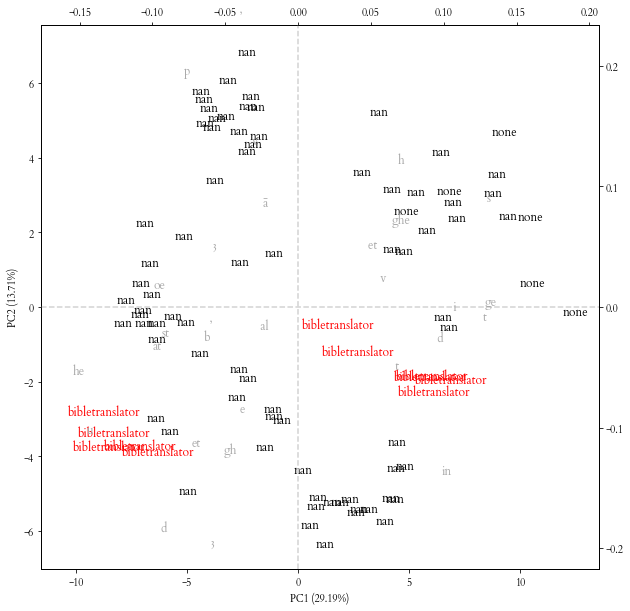

In [1532]:
import sklearn

def plot_pca(document_proj, loadings, var_exp, labels, sigs):
    # first the texts:
    fig, text_ax = plt.subplots(figsize=(10, 10))
    x1, x2 = documents_proj[:, 0], documents_proj[:, 1]
    text_ax.scatter(x1, x2, facecolors='none')
    for p1, p2, author, s in zip(x1, x2, labels, sigs):
        color = 'red' if s == 'bibletranslator' else 'black'
        if s == 'Wenen, ONB, 65':
            color = 'green'     
        text_ax.text(p1, p2, s, ha='center',
                     color=color, va='center', fontsize=12)

    # add variance information to the axis labels:
    text_ax.set_xlabel(f'PC1 ({var_exp[0] * 100:.2f}%)')
    text_ax.set_ylabel(f'PC2 ({var_exp[1] * 100:.2f}%)')
    
    # now the loadings:
    loadings_ax = text_ax.twinx().twiny()
    l1, l2 = loadings[:, 0], loadings[:, 1]
    lc = l1 * l2
    m = 30
    top_idxs = lc.argsort()[::-1][:m]
    
    loadings_ax.scatter(l1[top_idxs], l2[top_idxs], facecolors='none');
    for x, y, loading in zip(l1, l2, np.array(vec.get_feature_names_out())[top_idxs]):
        loadings_ax.text(x, y, loading, ha='center', va='center',
                         color='darkgrey', fontsize=12)

    mpl_axes_aligner.align.yaxes(text_ax, 0, loadings_ax, 0)
    mpl_axes_aligner.align.xaxes(text_ax, 0, loadings_ax, 0)
    
    # add lines through origins:
    plt.axvline(0, ls='dashed', c='lightgrey', zorder=0)
    plt.axhline(0, ls='dashed', c='lightgrey', zorder=0);

# fit the pca:
pca = sklearn.decomposition.PCA(n_components=2)
documents_proj = pca.fit_transform(BOW)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

plot_pca(documents_proj, loadings, var_exp, segments['scribe'], segments['translator'])

## Stylochronometry

/Users/wouter/anaconda3/envs/tf/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 7511 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wouter/anaconda3/envs/tf/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 7511 missing from current font.
  font.set_text(s, 0, flags=flags)


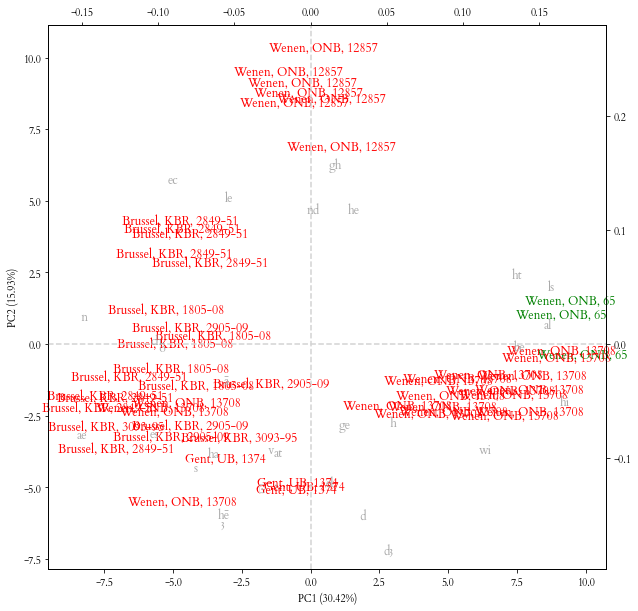

In [774]:
P = segments[segments['scribe'] == 'α']
vec = TfidfVectorizer(use_idf=True, max_features=100, ngram_range=(2, 2), analyzer='char')
BOW = vec.fit_transform(P['text']).toarray()
BOW = preprocessing.scale(BOW)
BOW.shape

def plot_pca(document_proj, loadings, var_exp, labels, sigs):
    # firs the texts:
    fig, text_ax = plt.subplots(figsize=(10, 10))
    x1, x2 = documents_proj[:, 0], documents_proj[:, 1]
    text_ax.scatter(x1, x2, facecolors='none')
    for p1, p2, author, s in zip(x1, x2, labels, sigs):
        color = 'red'
        if s == 'Wenen, ONB, 65':
            color = 'green'     
        text_ax.text(p1, p2, s, ha='center',
                     color=color, va='center', fontsize=12)

    # add variance information to the axis labels:
    text_ax.set_xlabel(f'PC1 ({var_exp[0] * 100:.2f}%)')
    text_ax.set_ylabel(f'PC2 ({var_exp[1] * 100:.2f}%)')
    
    # now the loadings:
    loadings_ax = text_ax.twinx().twiny()
    l1, l2 = loadings[:, 0], loadings[:, 1]
    lc = l1 * l2
    m = 30
    top_idxs = lc.argsort()[::-1][:m]
    
    loadings_ax.scatter(l1[top_idxs], l2[top_idxs], facecolors='none');
    for x, y, loading in zip(l1, l2, np.array(vec.get_feature_names_out())[top_idxs]):
        loadings_ax.text(x, y, loading, ha='center', va='center',
                         color='darkgrey', fontsize=12)

    mpl_axes_aligner.align.yaxes(text_ax, 0, loadings_ax, 0)
    mpl_axes_aligner.align.xaxes(text_ax, 0, loadings_ax, 0)
    
    # add lines through origins:
    plt.axvline(0, ls='dashed', c='lightgrey', zorder=0)
    plt.axhline(0, ls='dashed', c='lightgrey', zorder=0);

# fit the pca:
pca = sklearn.decomposition.PCA(n_components=2)
documents_proj = pca.fit_transform(BOW)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

plot_pca(documents_proj, loadings, var_exp, P['scribe'], P['signature'])

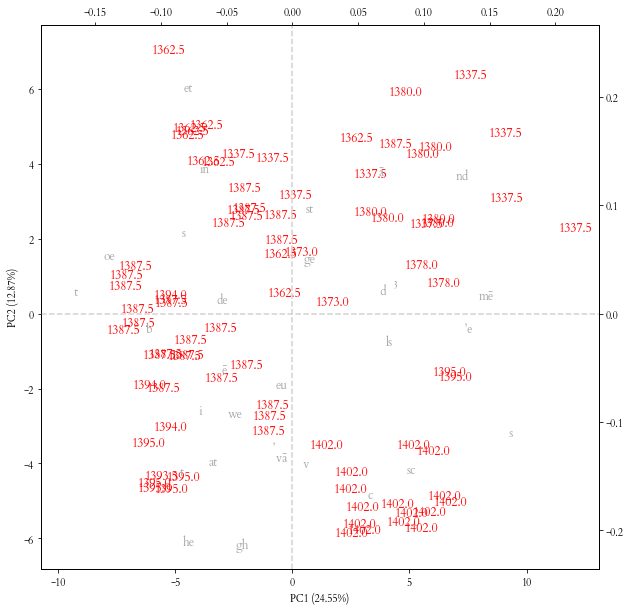

In [775]:
P = segments[segments['scribe'] == 'α']
P = segments[segments['signature'] != 'Wenen, ONB, 65']
vec = TfidfVectorizer(use_idf=True, max_features=100, ngram_range=(2, 2), analyzer='char')
BOW = vec.fit_transform(P['text']).toarray()
BOW = preprocessing.scale(BOW)
BOW.shape

def plot_pca(document_proj, loadings, var_exp, labels, sigs):
    # first the texts:
    fig, text_ax = plt.subplots(figsize=(10, 10))
    x1, x2 = documents_proj[:, 0], documents_proj[:, 1]
    text_ax.scatter(x1, x2, facecolors='none')
    for p1, p2, author, s in zip(x1, x2, labels, sigs):
        color = 'red'
        if s == 'Wenen, ONB, 65':
            color = 'green'     
        text_ax.text(p1, p2, s, ha='center',
                     color=color, va='center', fontsize=12)

    # add variance information to the axis labels:
    text_ax.set_xlabel(f'PC1 ({var_exp[0] * 100:.2f}%)')
    text_ax.set_ylabel(f'PC2 ({var_exp[1] * 100:.2f}%)')
    
    # now the loadings:
    loadings_ax = text_ax.twinx().twiny()
    l1, l2 = loadings[:, 0], loadings[:, 1]
    lc = l1 * l2
    m = 30
    top_idxs = lc.argsort()[::-1][:m]
    
    loadings_ax.scatter(l1[top_idxs], l2[top_idxs], facecolors='none');
    for x, y, loading in zip(l1, l2, np.array(vec.get_feature_names_out())[top_idxs]):
        loadings_ax.text(x, y, loading, ha='center', va='center',
                         color='darkgrey', fontsize=12)

    mpl_axes_aligner.align.yaxes(text_ax, 0, loadings_ax, 0)
    mpl_axes_aligner.align.xaxes(text_ax, 0, loadings_ax, 0)
    
    # add lines through origins:
    plt.axvline(0, ls='dashed', c='lightgrey', zorder=0)
    plt.axhline(0, ls='dashed', c='lightgrey', zorder=0);

# fit the pca:
pca = sklearn.decomposition.PCA(n_components=2)
documents_proj = pca.fit_transform(BOW)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

plot_pca(documents_proj, loadings, var_exp, P['scribe'], P['date'])

(85, 100)
85


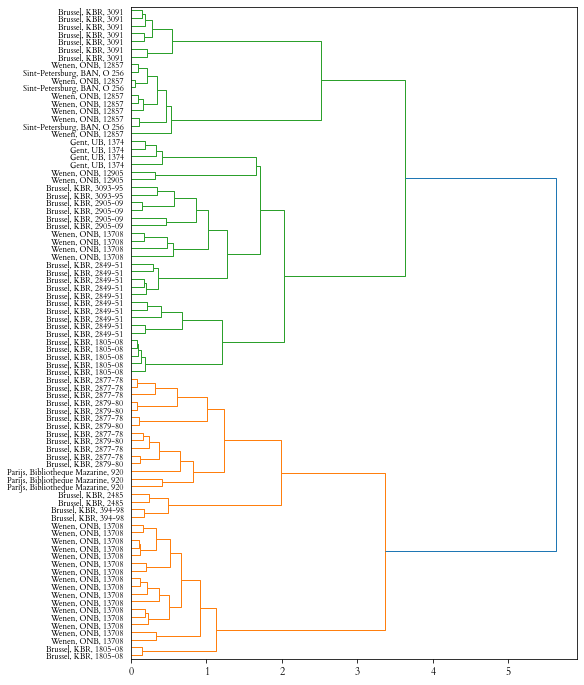

In [776]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hierarchy
import scipy.spatial.distance as scidist

print(BOW.shape)
print(len(P['signature']))

# 1. Calculate pairwise distances
dm = scidist.pdist(BOW, 'cosine')

# 2. Establish branch structure
linkage_object = hierarchy.linkage(dm, method='ward')

# 3. Visualize
def plot_tree(linkage_object, labels, figsize=(8, 12), ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    with plt.rc_context({'lines.linewidth': 1.0}):
        hierarchy.dendrogram(
            linkage_object, labels=labels,
            orientation='right',
            ax=ax,
            #link_color_func=lambda c: 'black',
            leaf_font_size=8, leaf_rotation=0)

plot_tree(linkage_object, list(P['signature']))

In [777]:
P = segments[(segments['scribe'] == 'α') & (P['signature'] != 'Wenen, ONB, 65')]
P.index = range(len(P))
P.head()

text    date scribe  \
0  m xjo Hier beghent sente matheꝰ BMwoec der ghe...  1387.5      α   
1  uwē Jc beent ē wilt u nᵗ ōtsien E peter seide...  1387.5      α   
2  e dierne go te hē segghēde E du waers mꝫ ihʼm...  1387.5      α   
3  ʼc seide hen minē kelct seldi sekʼ drekē e gh...  1387.5      α   
4  e vore hen dᵒech hi dbedde ī welc hi lach e g...  1387.5      α   

           signature                      id translator  
0  Wenen, ONB, 12857  Wenen, ONB, 12857-IV-α        NaN  
1  Wenen, ONB, 12857  Wenen, ONB, 12857-IV-α        NaN  
2  Wenen, ONB, 12857  Wenen, ONB, 12857-IV-α        NaN  
3  Wenen, ONB, 12857  Wenen, ONB, 12857-IV-α        NaN  
4  Wenen, ONB, 12857  Wenen, ONB, 12857-IV-α        NaN

In [778]:
vec = TfidfVectorizer(use_idf=True, max_features=1000, ngram_range=(1, 1), analyzer='char')
BOW = vec.fit_transform(P['text']).toarray()
BOW = preprocessing.scale(BOW)
BOW.shape

(52, 69)

In [779]:
n_iter = 1000

taus = []

for iter in tqdm(list(range(n_iter))):
    s = P.groupby('id').sample(1)
    ranks = np.argsort(s['date'])
    p = pd.DataFrame(BOW[s.index, :], columns=vec.get_feature_names_out())
    p = p.iloc[ranks]
    taus.append([kendalltau(p[f].values, range(0, len(p)))[1] for f in vec.get_feature_names_out()])
    
taus = pd.DataFrame(taus, columns=vec.get_feature_names_out())
taus

100%|██████████| 1000/1000 [00:09<00:00, 107.14it/s]


a         b         c         d         e         f  \
0    0.000256  0.000197  0.008324  0.016542  0.160293  0.000875  0.823643   
1    0.000035  0.000086  0.867267  0.143946  0.780545  0.000544  0.955577   
2    0.000544  0.000256  0.615766  0.102362  0.577009  0.011829  0.911288   
3    0.000086  0.000197  0.341843  0.070759  0.911288  0.003207  0.313980   
4    0.000331  0.000026  0.402030  0.070759  1.000000  0.003207  0.655598   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.000150  0.000048  0.080285  0.003916  0.867267  0.001376  0.313980   
996  0.000086  0.000692  0.655598  0.070759  0.867267  0.001100  0.468000   
997  0.000035  0.000086  0.217475  0.030889  0.468000  0.003916  0.341843   
998  0.000331  0.000035  0.102362  0.102362  0.911288  0.011829  0.823643   
999  0.000197  0.000064  0.287617  0.035776  0.402030  0.008324  0.780545   

                g         h         i  ...         ꝫ         ꝯ         ꝰ  \
0    8.745420e-04  0.738094  0.005759  ...  0.026573  1.000000  0.016542   
1    4.708996e-07  0.577009  0.002614  ...  0.003916  0.341843  0.022775   
2    9.677165e-06  0.696408  0.004760  ...  0.003207  0.468000  0.041289   
3    1.982589e-07  0.539412  0.005759  ...  0.019447  0.611618  0.102362   
4    6.428253e-05  0.738094  0.008324  ...  0.019447  0.615766  0.062158   
..            ...       ...       ...  ...       ...       ...       ...   
995  1.099829e-03  1.000000  0.054420  ...  0.054420  1.000000  0.035776   
996  4.819930e-06  0.655598  0.005759  ...  0.019447  0.313980  0.054420   
997  1.066659e-06  1.000000  0.006939  ...  0.006939  0.371199  0.026573   
998  4.778402e-05  0.823643  0.006939  ...  0.019447  1.000000  0.054420   
999  1.966328e-04  0.655598  0.022775  ...  0.011829  0.397400  0.019447   

                                                                        
0    0.097918       NaN  3.309855e-04  0.009943  0.128878  0.777873  0.954536  
1    0.097918       NaN  9.677165e-06  0.022775  0.160293  0.867267  0.954536  
2    0.097918       NaN  6.428253e-05  0.014017  0.262753  0.572630  0.924097  
3    0.097918       NaN  2.582817e-05  0.005759  0.143946  0.651740  0.954536  
4    0.097918  0.305579  2.614472e-03  0.047484  0.177968  0.865596  0.924097  
..        ...       ...           ...       ...       ...       ...       ...  
995  0.097918  0.305579  1.966328e-04  0.341843  0.177968  0.734979  0.954536  
996  0.097918       NaN  2.121218e-03  0.002614  0.341843  0.867267  0.954536  
997  0.097918       NaN  1.501558e-04  0.070759  0.197015  0.692896  1.000000  
998  0.097918       NaN  7.127534e-07  0.041289  0.239379  0.867267  0.954536  
999  0.097918       NaN  2.313311e-06  0.022775  0.102362  0.910065  0.924097  

[1000 rows x 69 columns]

/Users/wouter/anaconda3/envs/tf/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 7491 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wouter/anaconda3/envs/tf/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 7496 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wouter/anaconda3/envs/tf/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 7497 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wouter/anaconda3/envs/tf/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 7504 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wouter/anaconda3/envs/tf/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 7506 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wouter/anaconda3/envs/tf/lib/python3.9

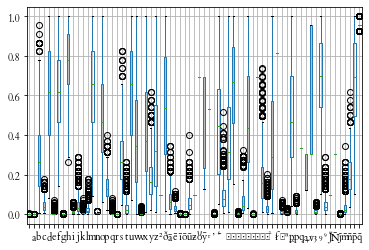

In [780]:
taus.boxplot();

/Users/wouter/anaconda3/envs/tf/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 7512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wouter/anaconda3/envs/tf/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 7496 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wouter/anaconda3/envs/tf/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 7506 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wouter/anaconda3/envs/tf/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 7491 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wouter/anaconda3/envs/tf/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 7515 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wouter/anaconda3/envs/tf/lib/python3.9

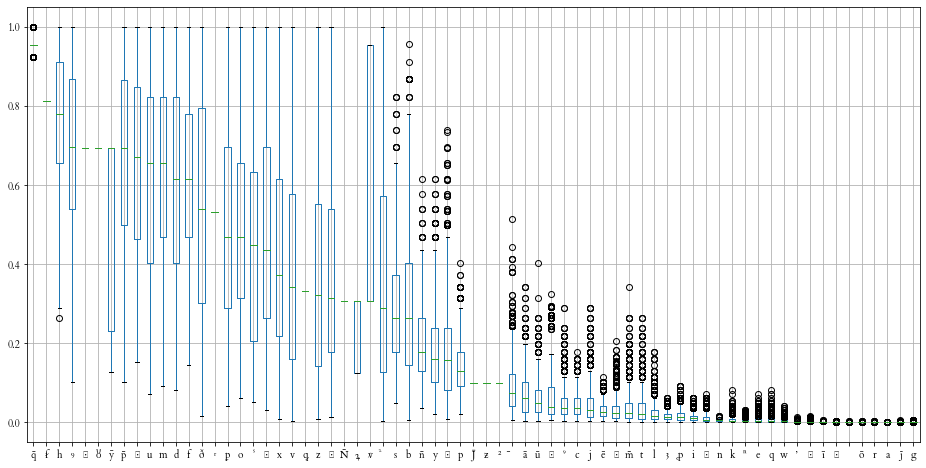

In [781]:
meds = taus.median()
meds.sort_values(ascending=False, inplace=True)
taus = taus[meds.index]
taus.boxplot(figsize=(16, 8));

In [782]:
meds.head().index

Index(['', 'ẜ', 'h', 'ꝯ', 'ᵘ'], dtype='object')

In [783]:
taus

         ẜ         h         ꝯ        ᵘ        ȣ         ȳ  \
0    0.954536  0.813097  0.738094  1.000000      NaN  0.69354  0.693540   
1    0.954536  0.813097  0.577009  0.341843  0.69354  0.69354  0.693540   
2    0.924097       NaN  0.696408  0.468000      NaN  0.69354  0.693540   
3    0.954536       NaN  0.539412  0.611618      NaN  0.69354  0.693540   
4    0.924097       NaN  0.738094  0.615766  0.69354  0.69354  0.693540   
..        ...       ...       ...       ...      ...      ...       ...   
995  0.954536  0.813097  1.000000  1.000000      NaN  0.69354  0.231215   
996  0.954536  0.813097  0.655598  0.313980      NaN  0.69354  0.693540   
997  1.000000  0.813097  1.000000  0.371199      NaN  0.69354  0.127412   
998  0.954536  0.813097  0.823643  1.000000  0.69354  0.69354  0.693540   
999  0.924097       NaN  0.655598  0.397400      NaN  0.69354  0.693540   

                     ᵈ         u  ...         ʼ         ᵉ         ī  \
0    0.777873  0.846640  0.143946  ...  0.001713  0.000256  0.001100   
1    0.867267  0.499218  0.217475  ...  0.000150  0.000544  0.000086   
2    0.572630  0.491928  0.197015  ...  0.000048  0.000048  0.000026   
3    0.651740  0.352829  0.313980  ...  0.000197  0.000256  0.000035   
4    0.865596  1.000000  0.615766  ...  0.001100  0.001100  0.000256   
..        ...       ...       ...  ...       ...       ...       ...   
995  0.734979  0.598637  0.262753  ...  0.004760  0.000331  0.000544   
996  0.867267  0.672787  0.468000  ...  0.000256  0.001376  0.000544   
997  0.692896  0.969144  0.615766  ...  0.000064  0.001713  0.000026   
998  0.867267  0.373641  0.823643  ...  0.001713  0.000331  0.000692   
999  0.910065  0.638197  0.503054  ...  0.001713  0.000086  0.000086   

            ᵗ                   ō         r         a               \
0    0.001376  0.000256  0.000086  0.000544  0.000197  3.309855e-04   
1    0.000544  0.000035  0.000048  0.000019  0.000086  9.677165e-06   
2    0.000026  0.000544  0.000026  0.000019  0.000256  6.428253e-05   
3    0.000197  0.000086  0.000197  0.000026  0.000197  2.582817e-05   
4    0.000150  0.000331  0.000331  0.000048  0.000026  2.614472e-03   
..        ...       ...       ...       ...       ...           ...   
995  0.000331  0.000150  0.000426  0.000544  0.000048  1.966328e-04   
996  0.000875  0.000086  0.000064  0.000114  0.000692  2.121218e-03   
997  0.000086  0.000035  0.000086  0.000026  0.000086  1.501558e-04   
998  0.000331  0.000331  0.000064  0.000256  0.000035  7.127534e-07   
999  0.000197  0.000197  0.000256  0.000197  0.000064  2.313311e-06   

                g  
0    8.745420e-04  
1    4.708996e-07  
2    9.677165e-06  
3    1.982589e-07  
4    6.428253e-05  
..            ...  
995  1.099829e-03  
996  4.819930e-06  
997  1.066659e-06  
998  4.778402e-05  
999  1.966328e-04  

[1000 rows x 69 columns]

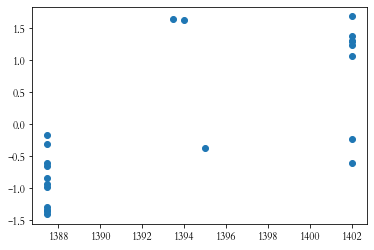

In [784]:
fig, ax = plt.subplots()

s = P.groupby('id').sample(1)
ranks = np.argsort(s['date'])
p = pd.DataFrame(BOW[s.index, :], columns=vec.get_feature_names_out())
p = p.iloc[ranks]
ax.scatter(s['date'], p['a'].values);

In [785]:
P

text    date scribe  \
0   m xjo Hier beghent sente matheꝰ BMwoec der ghe...  1387.5      α   
1   uwē Jc beent ē wilt u nᵗ ōtsien E peter seide...  1387.5      α   
2   e dierne go te hē segghēde E du waers mꝫ ihʼm...  1387.5      α   
3   ʼc seide hen minē kelct seldi sekʼ drekē e gh...  1387.5      α   
4   e vore hen dᵒech hi dbedde ī welc hi lach e g...  1387.5      α   
5   ʼlorē es tote dat hijt vōdē heuꝫ E alse hijt ...  1387.5      α   
6    gode ware mꝫ hē Jhʼc atwʼde e seide hē A ap...  1387.5      α   
7   ad coritheos j PAuwels ghehetē apostel jhʼu x...  1387.5      α   
8   latas pē heeft ī de gr̄e iᵛ xⁱ ī een ādʼ ewᵃng...  1387.5      α   
9   ppēbare also als mi behoert te spᵉkene Wā delt...  1387.5      α   
10   tᵒen es vā eeuwē teeuwē e de roede dʼ gerec...  1387.5      α   
11  ꝓlogo Hier beghīt de ꝓloge op actus apsor Nuca...  1387.5      α   
12  n dē vol ke leuʼen ō dꝫ sine selue do dē soudē...  1387.5      α   
13   heeft hē yets wat te seggene E hi nāmene e ...  1387.5      α   
14  Dens dach qᵃtʼ tēꝑe ī dē advēt diʼste lesse ys...  1387.5      α   
15  e hare vʼwādelē si ōtstakē te hare wʼt mꝫ onc...  1387.5      α   
16  DJt wʼc hebbic ī vele capittelē gedeilt ō datm...  1387.5      α   
17  edⁱnc E eest dꝫ si dit hʼdīkē nochtā toenē si...  1387.5      α   
18  ept was soe seit hi noch vā hē E ihʼs wae beg...  1387.5      α   
19  i si die woenē hʼe ī dinē huse si selē di lou...  1387.5      α   
20  Sente augustis waerde vā den scouwene ons hʼe...  1387.5      α   
21  ad Roma nos J Paulus die cnecht ihʼu xi ghehe...  1387.5      α   
22  Hier begēnen sʼ bʼnaʼts ouer peysingē vā dʼ me...  1387.5      α   
23  SEneca als wijt horē Was wt spaengē geborē Vā ...  1387.5      α   
24  ech wille wesen Sone cā hi te dien stōdē Jn hē...  1387.5      α   
25  Sʼ bernaert Jndē vijfstē boec vādʼ vierdʼ ꝑtie...  1387.5      α   
26  wē vʼeere saē Sōdʼ twiuel e waen rumen hʼen h...  1387.5      α   
27  Des paeꝰ nycholaꝰ decᵉtē vā dʼ electien wt dec...  1393.5      α   
28  hʼ ian vā rusbroec tgeloeue Dit maecte hʼ ian ...  1394.0      α   
29  se diē dꝫ hongʼt de hʼe ōtbendt de gevāgene E...  1394.0      α   
30  ine roc nemē late he oec dē mateltcꝰ Dā volcht...  1394.0      α   
31  Hier beghint een voʼredene op Sʼ gᵉgorius dyal...  1395.0      α   
32  mochte gesciē mʼ wat sine lede willē selē ocht...  1395.0      α   
33   vā bdc̄s hāt sine puede also hi plach E doe...  1395.0      α   
34   alle dese nedʼste dīgē si PEtrꝰ Jc sie dꝫ ic...  1395.0      α   
35  ie floreis geselle was ī dē wege gods wʼt geop...  1395.0      α   
36  Dander ꝑtie Van eusebiꝰ de bugge qᵃet ij De vo...  1402.0      α   
37  ī sinē kere Een wijf weenēde hʼde sere Om hare...  1402.0      α   
38  rede die soude staen Seker xxix iaer Die conīc...  1402.0      α   
39  Dandʼ partie Vor redene vā dē vijfstē boebe DJ...  1402.0      α   
40  ttē cᵒte verchiert al Dat dꝫ here gᵒt e smal ...  1402.0      α   
41  Dandʼ ꝑtie De vierde boec Vor redene vandē vie...  1402.0      α   
42  ie sone tē keyser waʼt E heeft hē dit geoppen...  1402.0      α   
43   mꝫ gᵒter werdē E bᵒchtēse eerlike ter erdes ...  1402.0      α   
44  Dandʼ ꝑtie De derde boec De vor redene vanden ...  1402.0      α   
45  Dander ptie Dē vorredene vā dē andʼen boeke WJ...  1402.0      α   
46  so dwīge Dat hi swege ī allē dīgē E nᵗ ē scon...  1402.0      α   
47  Hoe petʼ ordineʼde clemēte Vaeus te sine na he...  1402.0      α   
48  a Doemē screef mccc e xcvi op de derde none v...  1402.0      α   
49   iaer Houoriꝰ wʼt paus hier naer hoe Dit was e...  1402.0      α   
50  Dander ꝑtie De seuēde boec De vor redene vā dē...  1402.0      α   
51  gaen E diet te vorē hē wetē doen Als die andʼ...  1402.0      α   

                signature                           id       translator  
0       Wenen, ONB, 12857       Wenen, ONB, 12857-IV-α              NaN  
1       Wenen, ONB, 12857       Wenen, ONB, 12857-IV-α              NaN  
2       We

In [786]:
s = P.groupby('id').mean()
s
#ranks = np.argsort(s['date'])
#s.iloc[ranks]

<ipython-input-786-9d0850f70d32>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  s = P.groupby('id').mean()


date
id                                 
Brussel, KBR, 1805-08-I-α    1395.0
Brussel, KBR, 2849-51-III-α  1387.5
Brussel, KBR, 2849-51-IV-α   1387.5
Brussel, KBR, 2849-51-V-α    1387.5
Brussel, KBR, 2849-51-VI-α   1387.5
Brussel, KBR, 2849-51-VII-α  1387.5
Brussel, KBR, 2905-09-II-α   1387.5
Brussel, KBR, 3093-95-I-α    1387.5
Brussel, KBR, 3093-95-II-α   1387.5
Gent, UB, 1374-II-α          1387.5
Gent, UB, 1374-III-α         1387.5
Wenen, ONB, 12857-IV-α       1387.5
Wenen, ONB, 13708-II-α       1402.0
Wenen, ONB, 13708-III-α      1402.0
Wenen, ONB, 13708-IV-α       1402.0
Wenen, ONB, 13708-IX-α       1402.0
Wenen, ONB, 13708-V-α        1402.0
Wenen, ONB, 13708-VI-α       1402.0
Wenen, ONB, 13708-VII-α      1402.0
Wenen, ONB, 13708-VIII-α     1402.0
Wenen, ONB, 13708-X-α        1393.5
Wenen, ONB, 13708-XI-α       1394.0

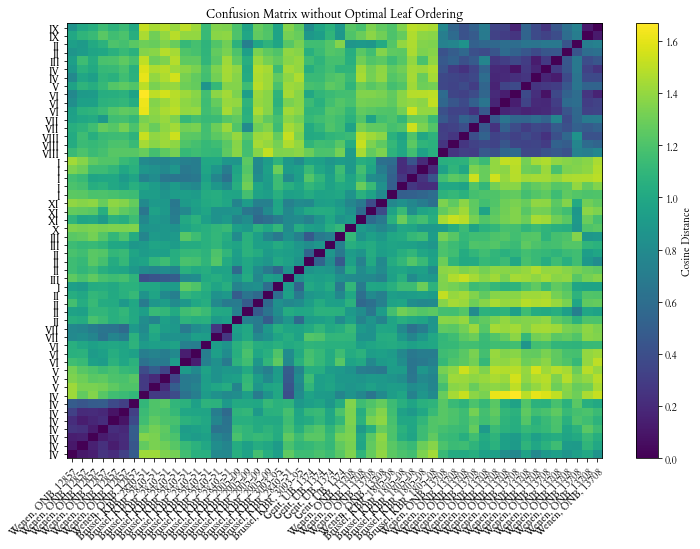

In [787]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial.distance as scidist
import scipy.cluster.hierarchy as hierarchy
import matplotlib.ticker as ticker

manuscript_signatures = P['signature'].tolist()
id_values = P['id'].tolist()

production_units = []

for id_value in id_values:
    production_unit_match = re.search(r'-(\d{1,}-)?([IVXLCDM]+)-', id_value) # get roman numerals
    production_units.append(production_unit_match.group(2))

dm = scidist.pdist(BOW, 'cosine') # pairwise distance using cosine
dm_square = scidist.squareform(dm)

# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the heatmap
im = ax.imshow(dm_square, cmap='viridis', aspect='auto', origin='lower')
plt.colorbar(im, label='Cosine Distance')

ax.set_xticks(np.arange(len(manuscript_signatures)))
ax.set_yticks(np.arange(len(production_units)))
ax.set_xticklabels(manuscript_signatures, rotation=90, rotation_mode='anchor')
ax.set_yticklabels(production_units)

# rotate the x-axis tick labels by 45 degrees
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.title('Confusion Matrix without Optimal Leaf Ordering')

plt.show()

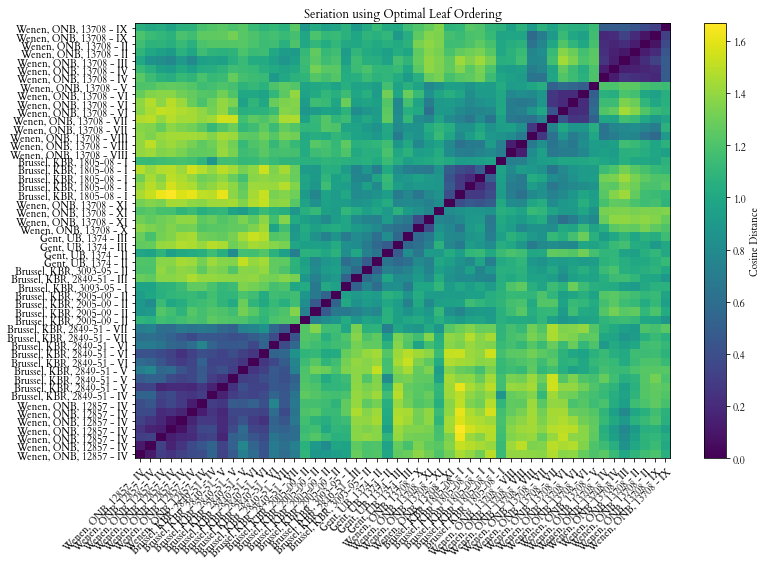

In [788]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial.distance as scidist
import scipy.cluster.hierarchy as hierarchy
import matplotlib.ticker as ticker

manuscript_signatures = P['signature'].tolist()
id_values = P['id'].tolist()

production_units = []

for id_value in id_values:
    production_unit_match = re.search(r'-(\d{1,}-)?([IVXLCDM]+)-', id_value) # get roman numerals
    production_units.append(production_unit_match.group(2))

dm = scidist.pdist(BOW, 'cosine') # pairwise distance using cosine
dm_square = scidist.squareform(dm)

linkage_matrix = hierarchy.linkage(dm, method='ward')

# Optimal leaf ordering! + get the ordered indices
optimal_ordering = hierarchy.optimal_leaf_ordering(linkage_matrix, dm)
ordered_indices = hierarchy.leaves_list(optimal_ordering)

ordered_dm = dm_square[:, ordered_indices][ordered_indices, :] # Reorder distance matrix

# reorder the manuscript signatures and production units
ordered_signatures = [f'{sig} - {unit}' for sig, unit in zip(manuscript_signatures, production_units)]
ordered_production_units = [f'{sig} - {unit}' for sig, unit in zip(manuscript_signatures, production_units)]

# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the heatmap
im = ax.imshow(ordered_dm, cmap='viridis', aspect='auto', origin='lower')
plt.colorbar(im, label='Cosine Distance')

ax.set_xticks(np.arange(len(ordered_signatures)))
ax.set_yticks(np.arange(len(ordered_production_units)))
ax.set_xticklabels(ordered_signatures, rotation=90, rotation_mode='anchor')
ax.set_yticklabels(ordered_production_units)

# rotate the x-axis tick labels by 45 degrees
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.title('Seriation using Optimal Leaf Ordering')

plt.show()

In [789]:
import altair as alt
import pandas as pd

# Create a DataFrame for the reordered distance matrix
df = pd.DataFrame(ordered_dm, columns=ordered_signatures, index=ordered_production_units).reset_index().melt(id_vars='index', var_name='columns')

# Create an interactive heatmap
heatmap = alt.Chart(df).mark_rect().encode(
    x=alt.X('columns:O', title=None, axis=alt.Axis(labelAngle=-45, labelFontSize=8, labelLimit=200)),
    y=alt.Y('index:O', title=None, axis=alt.Axis(labelFontSize=8, labelLimit=200)),
    color=alt.Color('value:Q', scale=alt.Scale(scheme='viridis'), legend=alt.Legend(title="Cosine Distance", gradientLength=500)),
    tooltip=[
        alt.Tooltip('columns:O', title='Signature - Production Unit'),
        alt.Tooltip('index:O', title='Matched Signature - Production Unit'),
        alt.Tooltip('value:Q', title='Cosine Distance', format='.4f')
    ]
).properties(
    width=500,
    height=500,
    title='Seriation using Optimal Leaf Ordering'
)

heatmap.display()


alt.Chart(...)

## Permutations

In [81]:
## not looking at date labels, predict the relative chronology
num_units = len(P['id'].unique())
unit_names = P['id'].unique()
print(num_units)

22


In [82]:
#permutations = list(itertools.permutations(range(num_units)))
#len(permutations)

In [106]:
import itertools
import random

num_units = len(P['id'].unique())
unit_names = P['id'].unique()

permutations = []
cnt = 0

# generate the first 20 permutations
for perm in itertools.permutations(range(num_units)):
    permutations.append(perm)
    cnt += 1
    if cnt > 20:
        break

# shuffle permutations
random.shuffle(permutations)